In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/ABIDE/")

Mounted at /content/drive


In [2]:

import sys
sys.path.append('/content/drive/MyDrive/ABIDE/')

In [3]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import pandas as pd
from sklearn import svm
import joblib
import openpyxl
from openpyxl import load_workbook
import os
import scipy.io as scio
import argparse
import numpy as np
import time
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
import torchvision.utils as vutils
from os.path import join
from os import listdir
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import DataLoader
from collections import OrderedDict
import nibabel as nib
import matplotlib.pyplot as plt
import cv2 as cv
from os import path
import shutil
import scipy.stats
import scipy.ndimage
import random
import torch.nn.init as init
import torch.nn.functional as F
import sys
import math
from functools import reduce
import operator
from scipy.interpolate import interp1d
from torch.optim import lr_scheduler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_selection import RFE

def feature_selection_fMRI(matrix, labels, train_ind, fnum):
    """
        matrix       : feature matrix (num_subjects x num_features)
        labels       : ground truth labels (num_subjects x 1)
        train_ind    : indices of the training samples
        fnum         : size of the feature vector after feature selection

    return:
        x_data      : feature matrix of lower dimension (num_subjects x fnum)
    """

    estimator = RidgeClassifier()
    selector = RFE(estimator, n_features_to_select=fnum, step=100, verbose=1)

    featureX = matrix[train_ind, :]
    featureY = labels[train_ind]
    selector = selector.fit(featureX, featureY.ravel())

    return selector
def feature_selection_sMRI(matrix, labels, train_ind, fnum):
    """
        matrix       : feature matrix (num_subjects x num_features)
        labels       : ground truth labels (num_subjects x 1)
        train_ind    : indices of the training samples
        fnum         : size of the feature vector after feature selection

    return:
        x_data      : feature matrix of lower dimension (num_subjects x fnum)
    """

    estimator = RidgeClassifier()
    selector = RFE(estimator, n_features_to_select=fnum, step=100, verbose=1)

    featureX = matrix[train_ind, :]
    featureY = labels[train_ind]
    selector = selector.fit(featureX, featureY.ravel())

    return selector

def get_index(lst=None, item=''):
	return [i for i in range(len(lst)) if lst[i] == item]

def flatten_one(length, img):
	'''
	  In some situations, the dimension on z-axis of images are smaller than
	  the dimension of z-axis of patches, this function will be used to pad
	'''

	one_line = np.zeros((1, int(length)))
	position = 0
	for i in range(img.shape[0]):  # column
		for j in range(i + 1, img.shape[1]):  # row
			one_line[0, position] = img[j, i]
			position = position + 1
	return one_line


def get_ids(num_subjects=None,dir_path=''):
	"""
	return:
		subject_IDs    : list of all subject IDs
	"""
	subject_IDs = np.genfromtxt(os.path.join(dir_path, 'subject_IDs.txt'), dtype=str)

	if num_subjects is not None:
		subject_IDs = subject_IDs[:num_subjects]

	return subject_IDs

def save_model(net,path, name_net):

  # This fucntion is used to save a specific model

    path_net =  path + '/' + name_net + '.pth'
    torch.save(net.cpu().state_dict(), path_net)
    net.cuda()

def load_model(net, path, name_net):

  # This function is used to load a specific model we saved before

    path_net =  path + '/' + name_net + '.pth'
    net.load_state_dict(torch.load(path_net))

    return net

def initialize():
  set_seed


def set_seed(seed=0):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

# initialize()

In [15]:
########################################### Load Data ###############################################
#####################################################################################################
#####################################################################################################
fMRI_atlas = 'CC200'  # AAL or CC200
phe = True

if phe == False:
  save_phe = '/without_phe/'
else:
  save_phe = '/with_phe/'

# fMRI path
save_path = '/content/drive/MyDrive/ABIDE/save_models/CC200_sMRI/'+ save_phe
root_path_fMRI = '/content/dataset'
if os.path.exists(root_path_fMRI):
  shutil.rmtree(root_path_fMRI)
shutil.copytree('/content/drive/MyDrive/ABIDE/' + fMRI_atlas + '/original/', root_path_fMRI)
label_dir = '/content/drive/MyDrive/ABIDE/phenotypic_image_quality'

# sMRI path
localDir = '/content/sMRI_dataset/'
if os.path.exists(localDir):
  shutil.rmtree(localDir)
os.makedirs(localDir)
!unzip '/content/drive/MyDrive/ABIDE/freesurfer_stats.zip' -d '/content/sMRI_dataset'
localDir = localDir + 'freesurfer_stats/'


k_fold = 5
new_number_features_fMRI = 4000
new_number_features_sMRI = 800
number_samples = 871
useless_samples = ['51334']
if fMRI_atlas == 'AAL':
  image_size = [116, 116]
else:
  image_size = [200, 200]
scaler = True


age_name = 'ages.mat'
gender_name = 'genders.mat'
label_name = 'ABIDE_label_871.mat'
label = scio.loadmat(os.path.join(label_dir, label_name))
label = label['label'][0]
labels = np.zeros(number_samples - len(useless_samples))
site_name = 'sites.mat'
site = scio.loadmat(os.path.join(label_dir, site_name))
all_sites = site['sites']
for i in range(len(all_sites)):
	site = all_sites[i]
	all_sites[i] = site.replace(' ', '')
unique_sites = np.unique(all_sites)
sites = []
unique_sites = list(unique_sites)

gender = scio.loadmat(os.path.join(label_dir, gender_name))
gender = gender['genders']
genders = np.zeros((number_samples - len(useless_samples), 1))

age = scio.loadmat(os.path.join(label_dir, age_name))
age = age['ages']
ages = np.zeros((number_samples - len(useless_samples), 1))

subject_IDs = get_ids(number_samples,dir_path=label_dir)
subject_IDs = subject_IDs.tolist()
length = image_size[0] * (image_size[1]-1) / 2
fMRI_images = np.zeros((number_samples - len(useless_samples), int(length)))

position = 0
print('constructing fMRI features')
for i in range(number_samples):
  subject_name = subject_IDs[i]
  if subject_name in useless_samples:
    subject_index = get_index(lst=subject_IDs, item=subject_name)
    print('The index for sample ' + subject_name + ' is : ', subject_index)
  else:
    image_name = subject_name + '.mat'
    subject_index = get_index(lst=subject_IDs, item=subject_name)
    image = scio.loadmat(os.path.join(root_path_fMRI, image_name))
    img = image['connectivity']

    idx = np.triu_indices_from(img, 1)
    fMRI_images[position, :] = img[idx]
    sites.append(all_sites[subject_index[0]])
    labels[position] = label[subject_index[0]]
    genders[position] = int(gender[subject_index[0]]) + 1
    ages[position] = float(age[subject_index[0]].replace(' ', ''))
    position = position + 1

if scaler == True:
	fMRI_images = StandardScaler().fit_transform(fMRI_images)

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/brainvol.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.aparc.a2009s.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.aparc.DKTatlas.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.aparc.pial.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.aparc.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.BA_exvivo.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.BA_exvivo.thresh.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.curv.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.w-g.pct.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/rh.aparc.a2009s.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/rh.aparc.DKTatlas.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/rh.aparc.pial.stats  
  inflating: /c

In [16]:
############################################### Load sMRI ###############################################################
############################################### Load sMRI ###############################################################
############################################### Load sMRI ###############################################################
############################################### Load Desikan_Killiany_features
left = 'lh.aparc.stats'
right = 'rh.aparc.stats'
number_roi = 68
feature_list = ['NumVert', 'SurfArea', 'GrayVol', 'ThickAvg', 'ThickStd', 'MeanCurv', 'GausCurv', 'FoldInd', 'CurvInd']
names = ['StructName', 'NumVert', 'SurfArea', 'GrayVol', 'ThickAvg', 'ThickStd', 'MeanCurv', 'GausCurv', 'FoldInd', 'CurvInd']
skiprows= list(range(0,61))
Desikan_Killiany_features = np.zeros((number_samples - len(useless_samples), number_roi * len(feature_list)))


position = 0
print('constructing Desikan-Killiany Atlas features')
for i in range(number_samples):
  subject_name = subject_IDs[i]
  if subject_name in useless_samples:
    subject_index = get_index(lst=subject_IDs, item=subject_name)
    print('The index for sample ' + subject_name + ' is : ', subject_index)
  else:
    table_left = pd.read_table(localDir + subject_name + '/' + left, sep='\s+', names=names,
						  skiprows=skiprows)
    table_right = pd.read_table(localDir + subject_name + '/' + right, sep='\s+', names=names,
						  skiprows=skiprows)

    for j in range(len(feature_list)):
      feature_name = feature_list[j]
      left_features = table_left[feature_name].values.tolist()
      right_features = table_right[feature_name].values.tolist()
      all_features = left_features + right_features
      if len(all_features) != number_roi:
       print('The sample ' + subject_name + ' has mistake!')
      all_features = np.array(all_features)
      Desikan_Killiany_features[position, j*number_roi : (j+1)*number_roi] = all_features
    position = position + 1

if scaler == True:
	for i in range(len(feature_list)):
		Desikan_Killiany_features[:, i * number_roi: (i+1) * number_roi] = StandardScaler().fit_transform(Desikan_Killiany_features[:, i * number_roi: (i+1) * number_roi])

print('finished')

############################################### Load aseg features
print('constructing aseg features')
number_roi_aseg = 45
aseg = 'aseg.stats'
feature_list_aseg = ['Number of Voxels', 'Volume', 'Intensity normMean', 'Itensity normStdDev', 'Intensity normMin', 'Intensity normMax', 'Intensity normRange']
names_aseg = ['ColHeader Index', 'Segmentation Id ', 'Number of Voxels', 'Volume', 'Structure Name', 'Intensity normMean', 'Itensity normStdDev', 'Intensity normMin', 'Intensity normMax', 'Intensity normRange']
skiprows_aseg= list(range(0,79))
aseg_features = np.zeros((number_samples - len(useless_samples), number_roi_aseg * len(feature_list_aseg)))

position = 0
for i in range(number_samples):
	subject_name = subject_IDs[i]
	if subject_name in useless_samples:
		subject_index = get_index(lst=subject_IDs, item=subject_name)
		print('The index for sample ' + subject_name + ' is : ', subject_index)
	else:
		table_left = pd.read_table(localDir + subject_name + '/' + aseg, sep='\s+', names=names_aseg,
						  skiprows=skiprows_aseg)
		for j in range(len(feature_list_aseg)):
			feature_name = feature_list_aseg[j]
			left_features = table_left[feature_name].values.tolist()
			if len(left_features) != number_roi_aseg:
				print('The sample ' + subject_name + ' has mistake!')
			all_features = np.array(left_features)
			aseg_features[position, j*number_roi_aseg : (j+1)*number_roi_aseg] = all_features
		position = position + 1

if scaler == True:
	for i in range(len(feature_list_aseg)):
		aseg_features[:, i * number_roi_aseg: (i+1) * number_roi_aseg] = StandardScaler().fit_transform(aseg_features[:, i * number_roi_aseg: (i+1) * number_roi_aseg])
print('finished')

############################################### Load wmparc features
number_roi_wmparc = 70
wmparc = 'wmparc.stats'
feature_list_wmparc = ['Number of Voxels', 'Volume', 'Intensity normMean', 'Itensity normStdDev', 'Intensity normMin', 'Intensity normMax', 'Intensity normRange']
names_wmparc = ['ColHeader Index', 'Segmentation Id ', 'Number of Voxels', 'Volume', 'Structure Name', 'Intensity normMean', 'Itensity normStdDev', 'Intensity normMin', 'Intensity normMax', 'Intensity normRange']
skiprows_wmparc= list(range(0,65))
wmparc_features = np.zeros((number_samples - len(useless_samples), number_roi_wmparc * len(feature_list_wmparc)))

print('constructing wmparc features')
position = 0
for i in range(number_samples):
	subject_name = subject_IDs[i]
	if subject_name in useless_samples:
		subject_index = get_index(lst=subject_IDs, item=subject_name)
		print('The index for sample ' + subject_name + ' is : ', subject_index)
	else:
		table_left = pd.read_table(localDir + subject_name + '/' + wmparc, sep='\s+', names = names_wmparc,
						  skiprows=skiprows_wmparc)
		for j in range(len(feature_list_wmparc)):
			feature_name = feature_list_wmparc[j]
			left_features = table_left[feature_name].values.tolist()
			if len(left_features) != number_roi_wmparc:
				print('The sample ' + subject_name + ' has mistake!')
			all_features = np.array(left_features)
			wmparc_features[position, j*number_roi_wmparc : (j+1)*number_roi_wmparc] = all_features
		position = position + 1
if scaler == True:
	for i in range(len(feature_list_wmparc)):
		wmparc_features[:, i * number_roi_wmparc: (i+1) * number_roi_wmparc] = StandardScaler().fit_transform(wmparc_features[:, i * number_roi_wmparc: (i+1) * number_roi_wmparc])
print('finished')

############################################### concatenation
sMRI_features = np.concatenate((Desikan_Killiany_features, aseg_features, wmparc_features),axis = 1)

constructing Desikan-Killiany Atlas features
The index for sample 51334 is :  [799]
finished
constructing aseg features
The index for sample 51334 is :  [799]
finished
constructing wmparc features
The index for sample 51334 is :  [799]
finished


In [17]:
############################################### phenotypic ###############################################################
############################################### phenotypic ###############################################################
############################################### phenotypic ###############################################################
ages_name = 'ages.mat'
ages = scio.loadmat(os.path.join(label_dir, ages_name))
ages = ages['ages']

gender_name = 'genders.mat'
genders = scio.loadmat(os.path.join(label_dir, gender_name))
genders = genders['genders']

FIQ_name = 'FIQS.mat'
FIQS = scio.loadmat(os.path.join(label_dir, FIQ_name))
FIQS = FIQS['FIQS']

NUM_name = 'NUM.mat'
NUM = scio.loadmat(os.path.join(label_dir, NUM_name))
NUMS = NUM['NUM']

PEC_name = 'PEC.mat'
PEC = scio.loadmat(os.path.join(label_dir, PEC_name))
PECS = PEC['PEC']

RAT_name = 'RAT.mat'
RAT = scio.loadmat(os.path.join(label_dir, RAT_name))
RATS = RAT['RAT']

age = np.zeros((number_samples - len(useless_samples), 1))
gender = np.zeros((number_samples - len(useless_samples), 1))
FIQ = np.zeros((number_samples - len(useless_samples), 1))
NUM = np.zeros((number_samples - len(useless_samples), 1))
PEC = np.zeros((number_samples - len(useless_samples), 1))
RAT = np.zeros((number_samples - len(useless_samples), 1))

position = 0
print('constructing phenotypic features')
for i in range(number_samples):
	subject_name = subject_IDs[i]
	if subject_name in useless_samples:
		subject_index = get_index(lst=subject_IDs, item=subject_name)
		print('The index for sample ' + subject_name + ' is : ', subject_index)
	else:
		subject_index = get_index(lst=subject_IDs, item=subject_name)
		age[position] = float(ages[subject_index[0]].replace(' ', ''))
		gender[position] = int(genders[subject_index[0]]) + 1
		FIQ[position] = int(FIQS[subject_index[0]])
		NUM[position] = float(NUMS[subject_index[0]])
		PEC[position] = float(PECS[subject_index[0]])
		RAT[position] = int(RATS[subject_index[0]])
		position = position + 1
FIQ[FIQ == -9999] = 108

if scaler == True:

  age[:,0] = np.squeeze(StandardScaler().fit_transform(np.expand_dims(age[:,0], axis = 1)))
  FIQ[:, 0] = np.squeeze(StandardScaler().fit_transform(np.expand_dims(FIQ[:, 0], axis = 1)))
  NUM[:, 0] = np.squeeze(StandardScaler().fit_transform(np.expand_dims(NUM[:, 0], axis = 1)))
  PEC[:, 0] = np.squeeze(StandardScaler().fit_transform(np.expand_dims(PEC[:, 0], axis = 1)))

# age, gender, FIQ, NUM, PEC, RAT
phe_features = np.concatenate((age, gender, FIQ, NUM, PEC, RAT),axis = 1)
print(phe_features.shape)


constructing phenotypic features
The index for sample 51334 is :  [799]
(870, 6)


In [18]:
dist_train = {}
dist_validation = {}
dist_test = {}
for i in range(k_fold):
	dist_train[str(i + 1)] = []
	dist_validation[str(i + 1)] = []
	dist_test[str(i + 1)] = []

for each_site in unique_sites:
	index_site = get_index(sites, each_site)
	label = np.zeros((len(index_site)))
	for i in range(len(index_site)):
		index = index_site[i]
		label[i] = int(labels[int(index)])
	########################################### StratifiedKFold ####################################################
	sfolder = StratifiedKFold(n_splits=k_fold,random_state=0,shuffle=True)
	group = 0
	for train, validation in sfolder.split(index_site,label):
		for i in train:
			dist_train[str(group + 1)].append(index_site[i])
			name = 0
		for j in validation:
			dist_validation[str(group + 1)].append(index_site[j])
			name = 0
		group = group+1

	group = 0
	for train, validation in sfolder.split(index_site,label):
		if group == 0:
			for j in validation:
				dist_test[str(group + k_fold)].append(index_site[j])
				dist_train[str(group + k_fold)].remove(index_site[j])
		else:
			for j in validation:
				dist_test[str(group)].append(index_site[j])
				dist_train[str(group)].remove(index_site[j])
		group = group+1

In [19]:
import torch.nn as nn
############################################### AUTO model ###############################################################
############################################### AUTO model ###############################################################
############################################### AUTO model ###############################################################
class Stacked_autoencoder(nn.Module):
	def __init__(self, in_c, hid_1, hid_2, hid_3, out, dropout_rate):

		super(Stacked_autoencoder, self).__init__()
		self.linear_1 = nn.Linear(in_features=in_c, out_features=hid_1)
		self.linear_2 = nn.Linear(in_features=hid_1, out_features=hid_2)
		self.linear_3 = nn.Linear(in_features=hid_2, out_features=hid_3)
		self.linear_4 = nn.Linear(in_features=hid_3, out_features=out)
		self.relu = nn.ReLU(inplace=True)
		self.dropout = nn.Dropout(dropout_rate)

	def forward(self, data):

		input_data = torch.flatten(data, start_dim=1, end_dim=-1)
		lin1 = self.relu(self.dropout(self.linear_1(input_data)))
		lin2 = self.relu(self.linear_2(lin1))
		lin3 = self.relu(self.linear_3(lin2))
		lin4 = self.relu(self.linear_4(lin3))

		return lin4

class MLP(nn.Module):
	def __init__(self, in_c, hid_1, hid_2, out, dropout_rate):

		super(MLP, self).__init__()
		self.linear_1 = nn.Linear(in_features=in_c, out_features=hid_1)
		self.linear_2 = nn.Linear(in_features=hid_1, out_features=hid_2)
		self.linear_3 = nn.Linear(in_features=hid_2, out_features=out)
		self.relu = nn.ReLU(inplace=True)
		self.dropout = nn.Dropout(dropout_rate)

	def forward(self, data):

		lin1 = self.relu(self.linear_1(data))
		lin2 = self.dropout(self.relu(self.linear_2(lin1)))
		lin3 = self.linear_3(lin2)

		return lin3


class Auto_encoder_MLP(nn.Module):
	def __init__(self, in_c, auto_1, auto_2, auto_3, MLP_1, MLP_2, MLP_out, dropout_rate):

		super(Auto_encoder_MLP, self).__init__()
		self.auto_encoder = Stacked_autoencoder(in_c, auto_1, auto_2, auto_3, in_c, dropout_rate)
		self.MLP = MLP(in_c, MLP_1, MLP_2, MLP_out, dropout_rate)
		self.softmax = nn.LogSoftmax(dim=1)

	def forward(self, data):

		auto_output = self.auto_encoder(data)
		MLP_out = self.MLP(auto_output)
		out = self.softmax(MLP_out)

		return out, auto_output


In [20]:
AUTO_labels = np.zeros((number_samples - len(useless_samples), 2))
for i in range(len(labels)):
    if labels[i] == 1:
        AUTO_labels[i,0] = 1
    else:
        AUTO_labels[i,1] = 1

data = {}
for fold in range(1, k_fold+1):

  data[str(fold)] = []
  selector_fMRI = feature_selection_fMRI(fMRI_images, labels, dist_train[str(fold)], new_number_features_fMRI)
  selector_sMRI = feature_selection_sMRI(sMRI_features, labels, dist_train[str(fold)], new_number_features_sMRI)

  new_fMRI_data = selector_fMRI.transform(fMRI_images)
  new_sMRI_data = selector_sMRI.transform(sMRI_features)
  ################################################# combine ##########################################
  if phe == True:
    fold_data = np.concatenate((new_fMRI_data,new_sMRI_data,phe_features), axis = 1)
    print(fold_data.shape)
  else:
    fold_data = np.concatenate((new_fMRI_data,new_sMRI_data), axis = 1)
    print(fold_data.shape)

  data[str(fold)].append(fold_data)
  data[str(fold)].append(AUTO_labels)


Fitting estimator with 19900 features.
Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17

In [21]:
############################################### Train, validaiton, test pipelines ###############################################################
############################################### Train, validaiton, test pipelines ###############################################################
############################################### Train, validaiton, test pipelines ###############################################################
def train_AUTO(args, model, all_data, fold_train_index, fold_validation_index, fold_test_index, scheduler):

    model.train()
    loss_function=torch.nn.MSELoss()

    data = torch.from_numpy(all_data[0])
    data = Variable(data, requires_grad=True)
    data = data.float()

    target = torch.from_numpy(all_data[1])
    target = target.float().long()


    if args.cuda:
        data, target = data.cuda(), target.cuda()

    data_train = data[fold_train_index,:]
    target = target[fold_train_index, :]
    scheduler.zero_grad()
    out,out_auto = model(data_train)

    cross_loss = torch.nn.functional.nll_loss(out, torch.max(target, 1)[1])
    data2 = torch.squeeze(data_train)
    MSE_loss = loss_function(out_auto,data2)
    total_loss = cross_loss + MSE_loss
    total_loss.backward()
    scheduler.step()

    out = torch.max(out, 1)[1]
    target = torch.max(target, 1)[1]
    target = target.cpu().numpy()
    out = out.cpu().numpy()

    ############################## validation and test ################################################################################
    val_target, val_out, val_loss = validation_AUTO(args, model, all_data, fold_validation_index)
    test_target, test_out, test_out_prob, test_loss = test_AUTO(args, model, all_data, fold_test_index)

    return model, target, out, total_loss.item(), val_target, val_out,val_loss, test_target, test_out, test_out_prob, test_loss


def validation_AUTO(args, model,all_data,  fold_validation_index):

    model.eval()
    loss_function=torch.nn.MSELoss()
    data = torch.from_numpy(all_data[0])
    data = Variable(data, requires_grad=False)
    data = data.float()

    target = torch.from_numpy(all_data[1])
    target = target.float().long()


    if args.cuda:
        data, target = data.cuda(), target.cuda()


    data_val = data[fold_validation_index,:]
    target = target[fold_validation_index, :]
    out,out_auto = model(data_val)

    cross_loss = torch.nn.functional.nll_loss(out, torch.max(target, 1)[1])
    data2 = torch.squeeze(data_val)
    MSE_loss = loss_function(out_auto,data2)
    total_loss = cross_loss + MSE_loss

    out = torch.max(out, 1)[1]
    target = torch.max(target, 1)[1]
    target = target.cpu().numpy()
    out = out.cpu().numpy()

    return target, out, total_loss.item()


def test_AUTO(args, model, all_data,  fold_test_index):

    model.eval()
    loss_function=torch.nn.MSELoss()

    data = torch.from_numpy(all_data[0])
    data = Variable(data, requires_grad=False)
    data = data.float()

    target = torch.from_numpy(all_data[1])
    target = target.float().long()


    if args.cuda:
        data, target = data.cuda(), target.cuda()

    data_test = data[fold_test_index,:]
    target = target[fold_test_index, :]
    out,out_auto = model(data_test)

    cross_loss = torch.nn.functional.nll_loss(out, torch.max(target, 1)[1])
    data2 = torch.squeeze(data_test)
    MSE_loss = loss_function(out_auto,data2)
    total_loss = cross_loss + MSE_loss

    out_prob = torch.exp(out)
    out = torch.max(out, 1)[1]
    target = torch.max(target, 1)[1]
    target = target.cpu().numpy()
    out = out.cpu().numpy()
    out_prob = out_prob.cpu().detach().numpy()

    return target, out, out_prob, total_loss.item()



In [22]:
########################################### Training setting ################################################
########################################### Training setting ################################################
########################################### Training setting ################################################
parser = argparse.ArgumentParser()
parser.add_argument('--ngpu', type=int, default=1)
parser.add_argument('--nEpochs', type=int, default=200)
parser.add_argument('--no-cuda', action='store_true')
parser.add_argument('--seed', type=int, default=1)
parser.add_argument('--lr', type=str, default=8e-4)
# I define three kinds of optimizer, adam sgd and rmsprop, but adam performs the best
parser.add_argument('--opt', type=str, default='adam')
parser.add_argument('--auto_in', type=int, default=fold_data.shape[1])
parser.add_argument('--auto_hid_1', type=int, default=500)
parser.add_argument('--auto_hid_2', type=int, default=150)
parser.add_argument('--auto_hid_3', type=int, default=500)
parser.add_argument('--MLP_1', type=int, default=300)
parser.add_argument('--MLP_2', type=int, default=16)
parser.add_argument('--MLP_out', type=int, default=2)
parser.add_argument('--dropout_rate', type=int, default=0.5)


args, unknown = parser.parse_known_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

gpu_ids = range(args.ngpu)
train = train_AUTO


  + Number of params: 6408906
Save models
Train Epoch: 1: train loss : 1.70354795	 train accuracy : 0.54598826	 val accuracy : 0.52747253	 test accuracy : 0.51412429	
Save models
Train Epoch: 2: train loss : 1.66816783	 train accuracy : 0.55381605	 val accuracy : 0.52747253	 test accuracy : 0.51977401	
Save models
Train Epoch: 3: train loss : 1.66745150	 train accuracy : 0.53620352	 val accuracy : 0.52747253	 test accuracy : 0.51977401	
Save models
Train Epoch: 4: train loss : 1.63748515	 train accuracy : 0.54990215	 val accuracy : 0.52747253	 test accuracy : 0.51977401	
Save models
Train Epoch: 5: train loss : 1.62644637	 train accuracy : 0.55577299	 val accuracy : 0.54945055	 test accuracy : 0.50282486	
Train Epoch: 6: train loss : 1.59535027	 train accuracy : 0.61448141	 val accuracy : 0.53296703	 test accuracy : 0.51977401	
Train Epoch: 7: train loss : 1.61948752	 train accuracy : 0.63796477	 val accuracy : 0.53296703	 test accuracy : 0.51977401	
Save models
Train Epoch: 8: train l

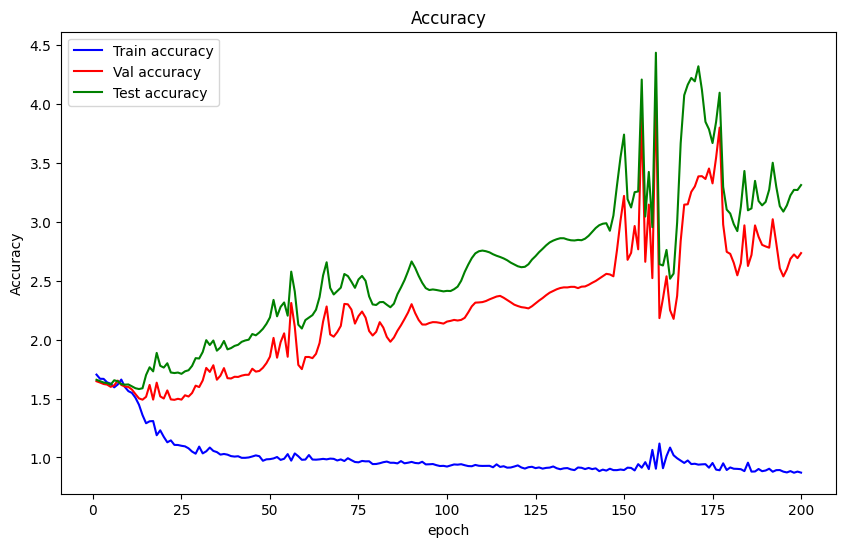

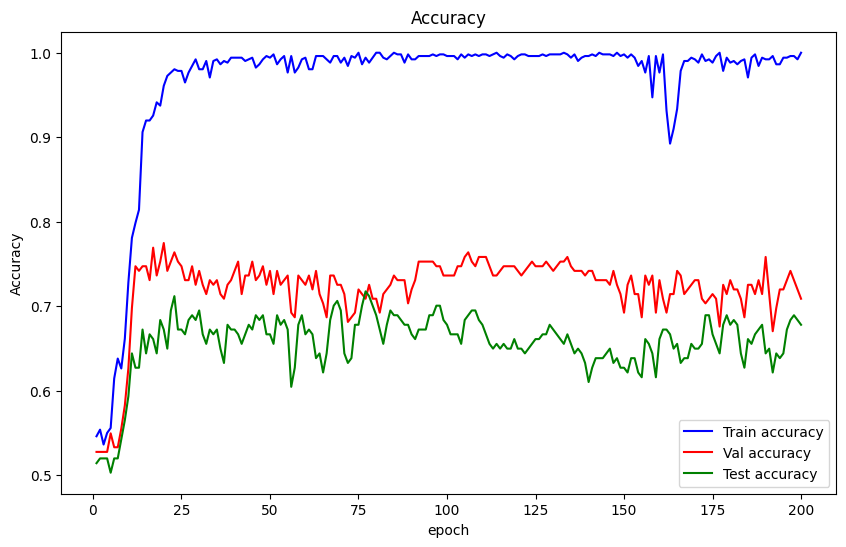



In fold  1
The best validaiton accuracy is:  0.7747252747252747
Happened at epoch:  20
The corresponding test accuracy 0.672316384180791
The corresponding test AUC is:  0.7478260869565218




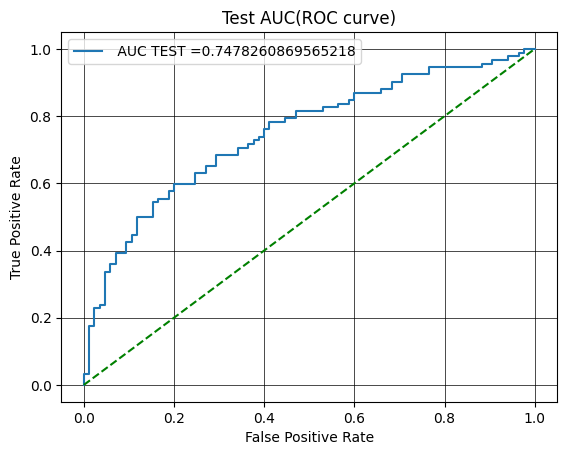

  + Number of params: 6408906
Save models
Train Epoch: 1: train loss : 1.70395374	 train accuracy : 0.45664740	 val accuracy : 0.53107345	 test accuracy : 0.47126437	
Train Epoch: 2: train loss : 1.67125928	 train accuracy : 0.48940270	 val accuracy : 0.48022599	 test accuracy : 0.46551724	
Train Epoch: 3: train loss : 1.66762280	 train accuracy : 0.45664740	 val accuracy : 0.49717514	 test accuracy : 0.44252874	
Save models
Train Epoch: 4: train loss : 1.64910305	 train accuracy : 0.49518304	 val accuracy : 0.54237288	 test accuracy : 0.47126437	
Train Epoch: 5: train loss : 1.63484800	 train accuracy : 0.50481696	 val accuracy : 0.53107345	 test accuracy : 0.46551724	
Train Epoch: 6: train loss : 1.61679244	 train accuracy : 0.51830443	 val accuracy : 0.51412429	 test accuracy : 0.47126437	
Train Epoch: 7: train loss : 1.61428189	 train accuracy : 0.50674374	 val accuracy : 0.53672316	 test accuracy : 0.47126437	
Save models
Train Epoch: 8: train loss : 1.59595740	 train accuracy : 0

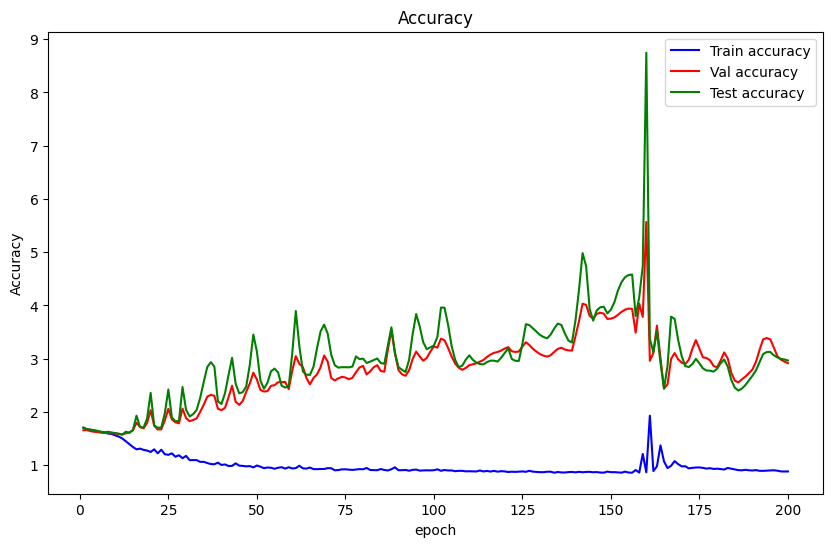

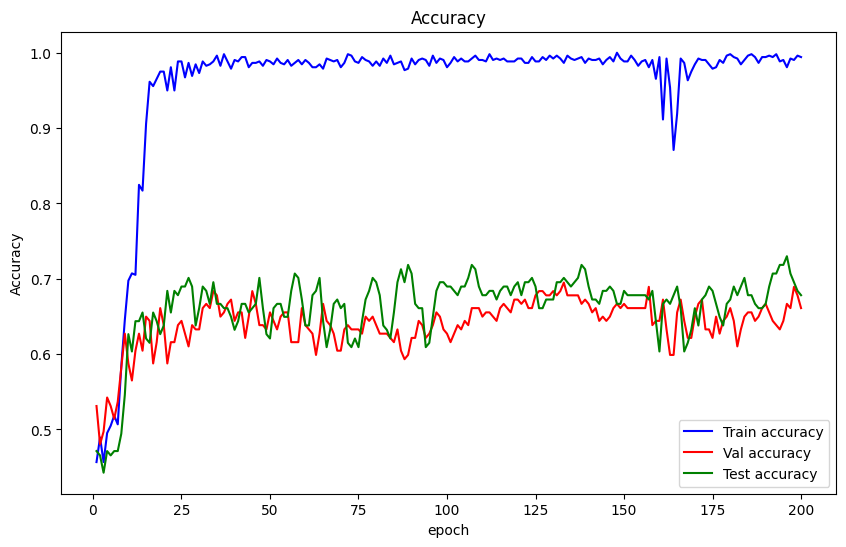



In fold  2
The best validaiton accuracy is:  0.6949152542372882
Happened at epoch:  133
The corresponding test accuracy 0.7011494252873564
The corresponding test AUC is:  0.6933492632417364




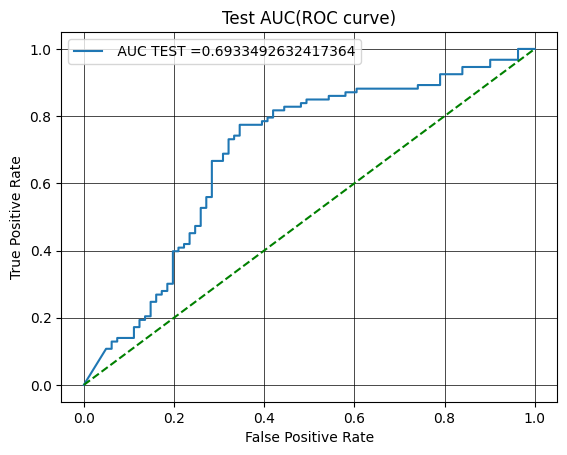

  + Number of params: 6408906
Save models
Train Epoch: 1: train loss : 1.68114007	 train accuracy : 0.45247148	 val accuracy : 0.53448276	 test accuracy : 0.55294118	
Train Epoch: 2: train loss : 1.66646409	 train accuracy : 0.51520913	 val accuracy : 0.46551724	 test accuracy : 0.44705882	
Train Epoch: 3: train loss : 1.65168464	 train accuracy : 0.49619772	 val accuracy : 0.42528736	 test accuracy : 0.48235294	
Train Epoch: 4: train loss : 1.64038658	 train accuracy : 0.51330798	 val accuracy : 0.47126437	 test accuracy : 0.50588235	
Train Epoch: 5: train loss : 1.63441014	 train accuracy : 0.55703422	 val accuracy : 0.48275862	 test accuracy : 0.53529412	
Save models
Train Epoch: 6: train loss : 1.61637044	 train accuracy : 0.61406844	 val accuracy : 0.58045977	 test accuracy : 0.64117647	
Save models
Train Epoch: 7: train loss : 1.59798932	 train accuracy : 0.69201521	 val accuracy : 0.61494253	 test accuracy : 0.63529412	
Save models
Train Epoch: 8: train loss : 1.58816540	 train 

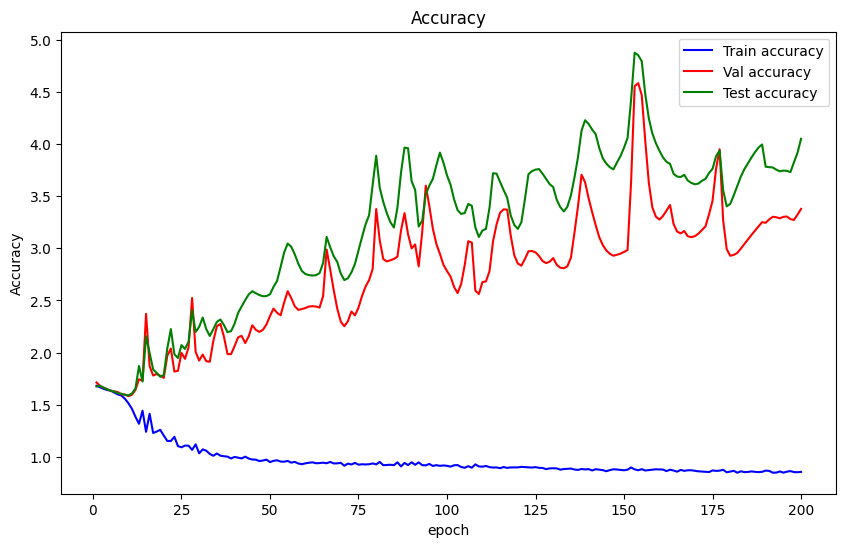

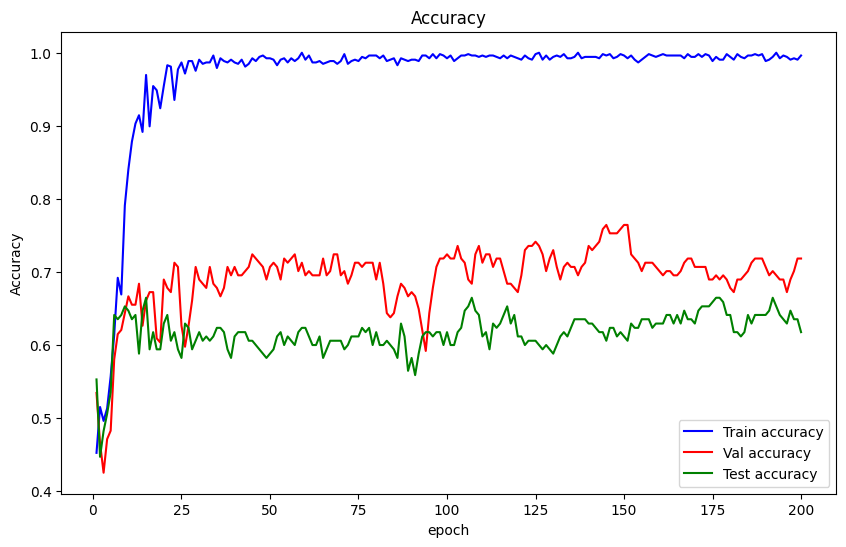



In fold  3
The best validaiton accuracy is:  0.764367816091954
Happened at epoch:  151
The corresponding test accuracy 0.6058823529411764
The corresponding test AUC is:  0.660624300111982




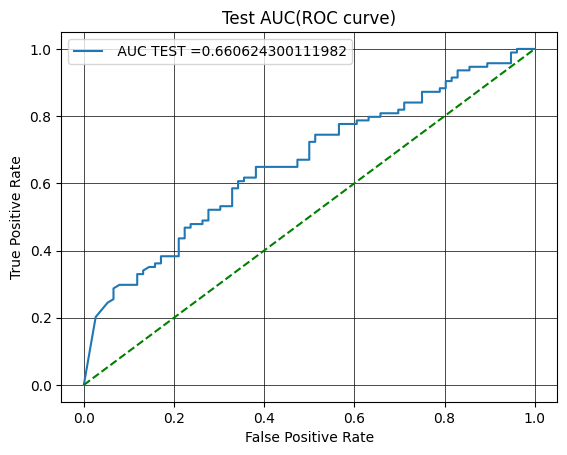

  + Number of params: 6408906
Save models
Train Epoch: 1: train loss : 1.69514275	 train accuracy : 0.47279550	 val accuracy : 0.54117647	 test accuracy : 0.50898204	
Train Epoch: 2: train loss : 1.66692674	 train accuracy : 0.50093809	 val accuracy : 0.44705882	 test accuracy : 0.44910180	
Train Epoch: 3: train loss : 1.65340900	 train accuracy : 0.47279550	 val accuracy : 0.44705882	 test accuracy : 0.44910180	
Train Epoch: 4: train loss : 1.63753176	 train accuracy : 0.47091932	 val accuracy : 0.47058824	 test accuracy : 0.47305389	
Train Epoch: 5: train loss : 1.62374830	 train accuracy : 0.49155722	 val accuracy : 0.51176471	 test accuracy : 0.47305389	
Train Epoch: 6: train loss : 1.61317968	 train accuracy : 0.50656660	 val accuracy : 0.52352941	 test accuracy : 0.49101796	
Train Epoch: 7: train loss : 1.60788524	 train accuracy : 0.56472795	 val accuracy : 0.52941176	 test accuracy : 0.52095808	
Train Epoch: 8: train loss : 1.60645902	 train accuracy : 0.60787992	 val accuracy 

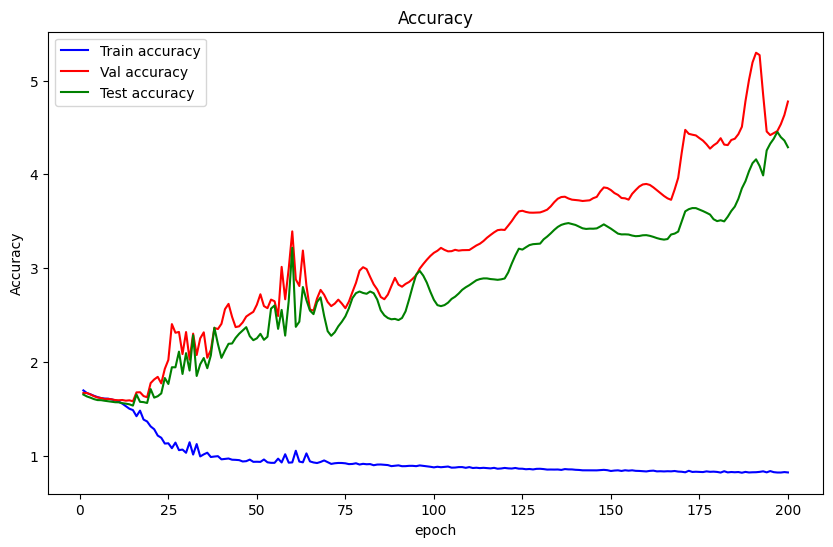

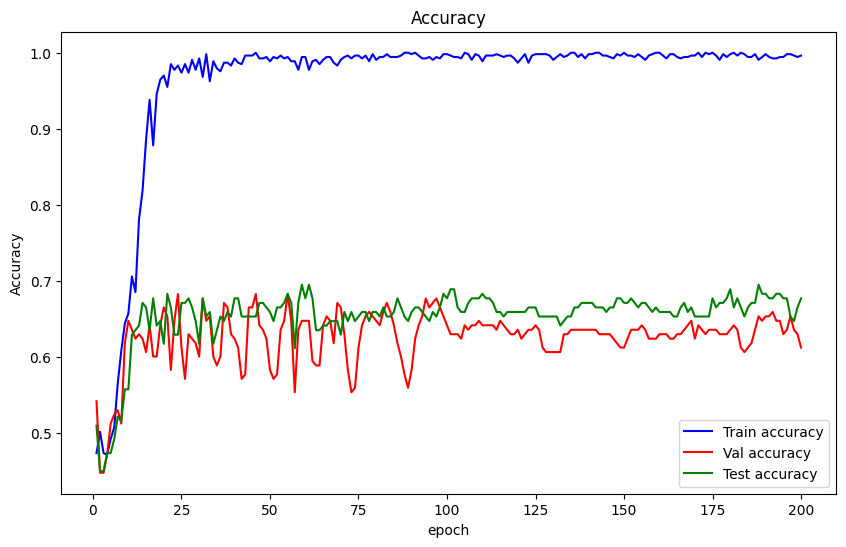



In fold  4
The best validaiton accuracy is:  0.6823529411764706
Happened at epoch:  55
The corresponding test accuracy 0.6826347305389222
The corresponding test AUC is:  0.7021739130434783




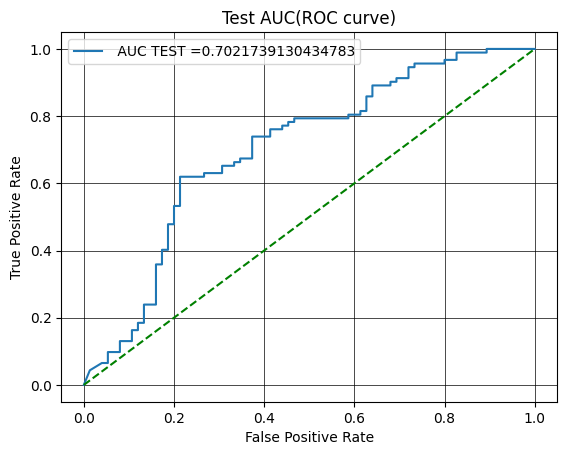

  + Number of params: 6408906
Save models
Train Epoch: 1: train loss : 1.70362711	 train accuracy : 0.53550864	 val accuracy : 0.55089820	 test accuracy : 0.52747253	
Save models
Train Epoch: 2: train loss : 1.67937255	 train accuracy : 0.52975048	 val accuracy : 0.55089820	 test accuracy : 0.52747253	
Save models
Train Epoch: 3: train loss : 1.66211629	 train accuracy : 0.53166987	 val accuracy : 0.55089820	 test accuracy : 0.52747253	
Save models
Train Epoch: 4: train loss : 1.64955473	 train accuracy : 0.53358925	 val accuracy : 0.55089820	 test accuracy : 0.52747253	
Save models
Train Epoch: 5: train loss : 1.63446844	 train accuracy : 0.53934741	 val accuracy : 0.55089820	 test accuracy : 0.52747253	
Save models
Train Epoch: 6: train loss : 1.62102699	 train accuracy : 0.52975048	 val accuracy : 0.55089820	 test accuracy : 0.52747253	
Save models
Train Epoch: 7: train loss : 1.62300098	 train accuracy : 0.55086372	 val accuracy : 0.56886228	 test accuracy : 0.52747253	
Save models

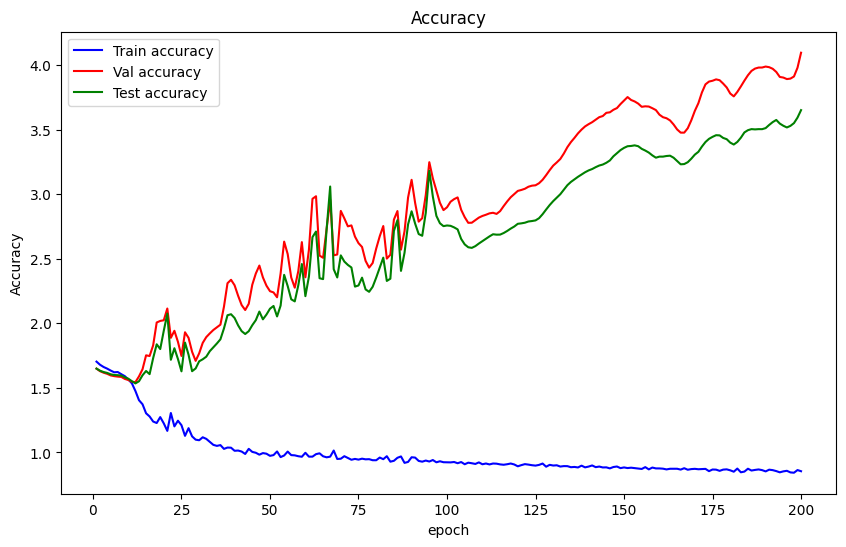

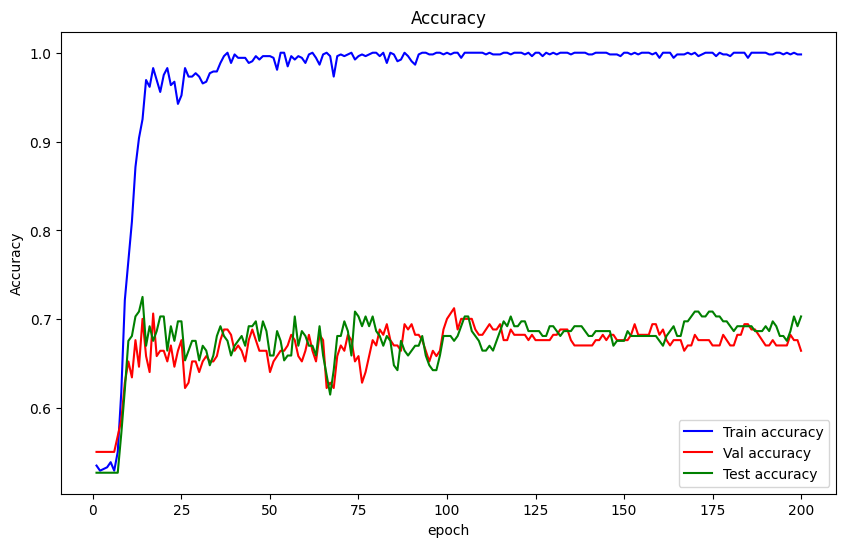



In fold  5
The best validaiton accuracy is:  0.7125748502994012
Happened at epoch:  102
The corresponding test accuracy 0.6758241758241759
The corresponding test AUC is:  0.7030038759689923




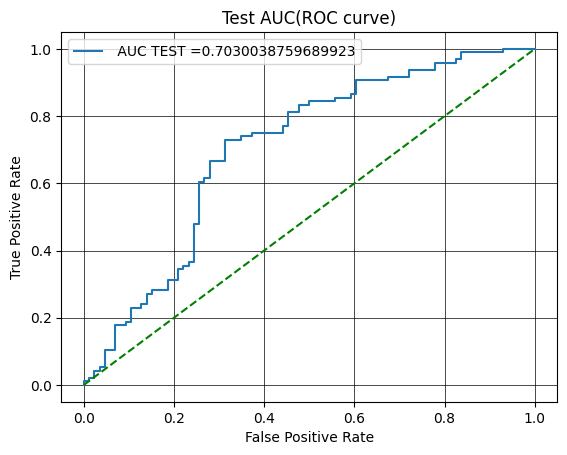

Finish 5-fold training


In [23]:
########################################### Training ################################################
########################################### Training ################################################
########################################### Training ################################################
for fold in range(1, k_fold+1):
  model = Auto_encoder_MLP(in_c=args.auto_in, auto_1=args.auto_hid_1, auto_2=args.auto_hid_2, auto_3=args.auto_hid_3, MLP_1=args.MLP_1, MLP_2=args.MLP_2, MLP_out=args.MLP_out, dropout_rate=args.dropout_rate)
  print('  + Number of params: {}'.format(
    sum([p.data.nelement() for p in model.parameters()])))
  model = nn.parallel.DataParallel(model, device_ids=gpu_ids)
  if args.cuda:
    model = model.cuda()
  optimizer = optim.Adam(model.parameters(), lr = args.lr)

  best_validation_accuracy = 0
  Train_accuracy_list =[]
  Train_loss_list = []
  Val_accuracy_list =[]
  Val_loss_list = []
  Test_accuracy_list =[]
  Test_loss_list = []

  for epoch in range(1, args.nEpochs + 1):

    model, train_target, train_out, train_loss, val_target, val_out, val_loss, test_target, test_out, test_prob, test_loss = train(args, model, data[str(fold)], dist_train[str(fold)], dist_validation[str(fold)], dist_test[str(fold)], optimizer)

    train_accuracy = metrics.accuracy_score(train_target, train_out)
    val_accuracy = metrics.accuracy_score(val_target, val_out)
    test_accuracy = metrics.accuracy_score(test_target, test_out)
    Train_accuracy_list.append(train_accuracy)
    Val_accuracy_list.append(val_accuracy)
    Test_accuracy_list.append(test_accuracy)
    Train_loss_list.append(train_loss)
    Val_loss_list.append(val_loss)
    Test_loss_list.append(test_loss)

    if val_accuracy >=best_validation_accuracy:
      best_epoch = epoch
      best_validation_accuracy = val_accuracy
      corresponding_val_out = val_out
      corresponding_test_accuracy = test_accuracy
      corresponding_test_out = test_out
      corresponding_test_prob = test_prob

      print('Save models')
      save_model(model, save_path, 'AUTO_'+str(fold))

    print('Train Epoch: ' + str(epoch) + ': train loss : {:.8f}\t train accuracy : {:.8f}\t val accuracy : {:.8f}\t test accuracy : {:.8f}\t'.format(
      train_loss, train_accuracy, val_accuracy, test_accuracy))

  if fold == 1:
    all_fold_val_label = val_target
    all_fold_val_out = corresponding_val_out
    all_fold_test_label = test_target
    all_fold_test_out = corresponding_test_out
    all_fold_test_prob = corresponding_test_prob
  else:
    all_fold_val_label = np.concatenate((all_fold_val_label, val_target),axis = 0)
    all_fold_val_out = np.concatenate((all_fold_val_out, corresponding_val_out),axis = 0)
    all_fold_test_label = np.concatenate((all_fold_test_label, test_target),axis = 0)
    all_fold_test_out = np.concatenate((all_fold_test_out, corresponding_test_out),axis = 0)
    all_fold_test_prob = np.concatenate((all_fold_test_prob, corresponding_test_prob),axis = 0)

  x_axis = list(range(1, len(Train_accuracy_list)+1))
  plt.figure(figsize=(10,6))
  plt.plot(x_axis, Train_loss_list, c='b',label='Train accuracy')
  plt.plot(x_axis, Val_loss_list, c='r',label='Val accuracy')
  plt.plot(x_axis, Test_loss_list, c='g',label='Test accuracy')
  plt.title("Accuracy")
  plt.xlabel("epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

  plt.figure(figsize=(10,6))
  plt.plot(x_axis, Train_accuracy_list, c='b',label='Train accuracy')
  plt.plot(x_axis, Val_accuracy_list, c='r',label='Val accuracy')
  plt.plot(x_axis, Test_accuracy_list, c='g',label='Test accuracy')
  plt.title("Accuracy")
  plt.xlabel("epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()


  test_fpr, test_tpr, te_thresholds = roc_curve(test_target, corresponding_test_prob[:,1],pos_label=1)
  test_auc = auc(test_fpr, test_tpr)
  print('\n')
  print('In fold ',str(fold))
  print('The best validaiton accuracy is: ',best_validation_accuracy)
  print('Happened at epoch: ',best_epoch)
  print('The corresponding test accuracy', corresponding_test_accuracy)
  print('The corresponding test AUC is: ',test_auc)
  print('\n')


  plt.grid()
  plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
  plt.plot([0,1],[0,1],'g--')
  plt.legend()
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Test AUC(ROC curve)")
  plt.grid(color='black', linestyle='-', linewidth=0.5)
  plt.show()

print('Finish 5-fold training')


The best validation accuracy is  0.7264367816091954
The corresponding test accuracy is  0.667816091954023
The corresponding test AUC is:  0.6889442670336503


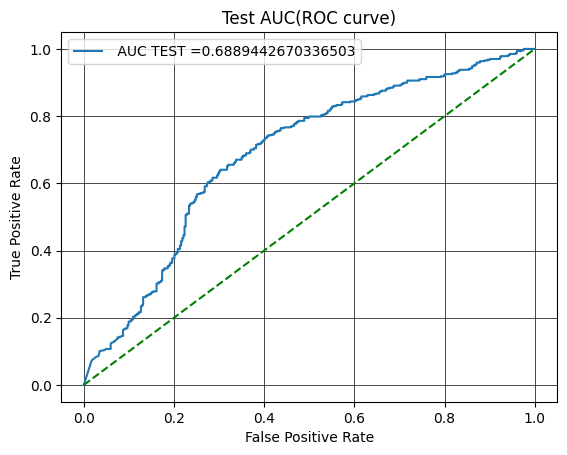

In [24]:
val_accuracy = metrics.accuracy_score(all_fold_val_label, all_fold_val_out)
test_accuracy = metrics.accuracy_score(all_fold_test_label, all_fold_test_out)
test_fpr, test_tpr, te_thresholds = roc_curve(all_fold_test_label, all_fold_test_prob[:,1],pos_label=1)
test_auc = auc(test_fpr, test_tpr)
print('The best validation accuracy is ',val_accuracy)
print('The corresponding test accuracy is ',test_accuracy)
print('The corresponding test AUC is: ',test_auc)
plt.grid()
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

Ensemble  1
Fitting estimator with 19900 features.


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

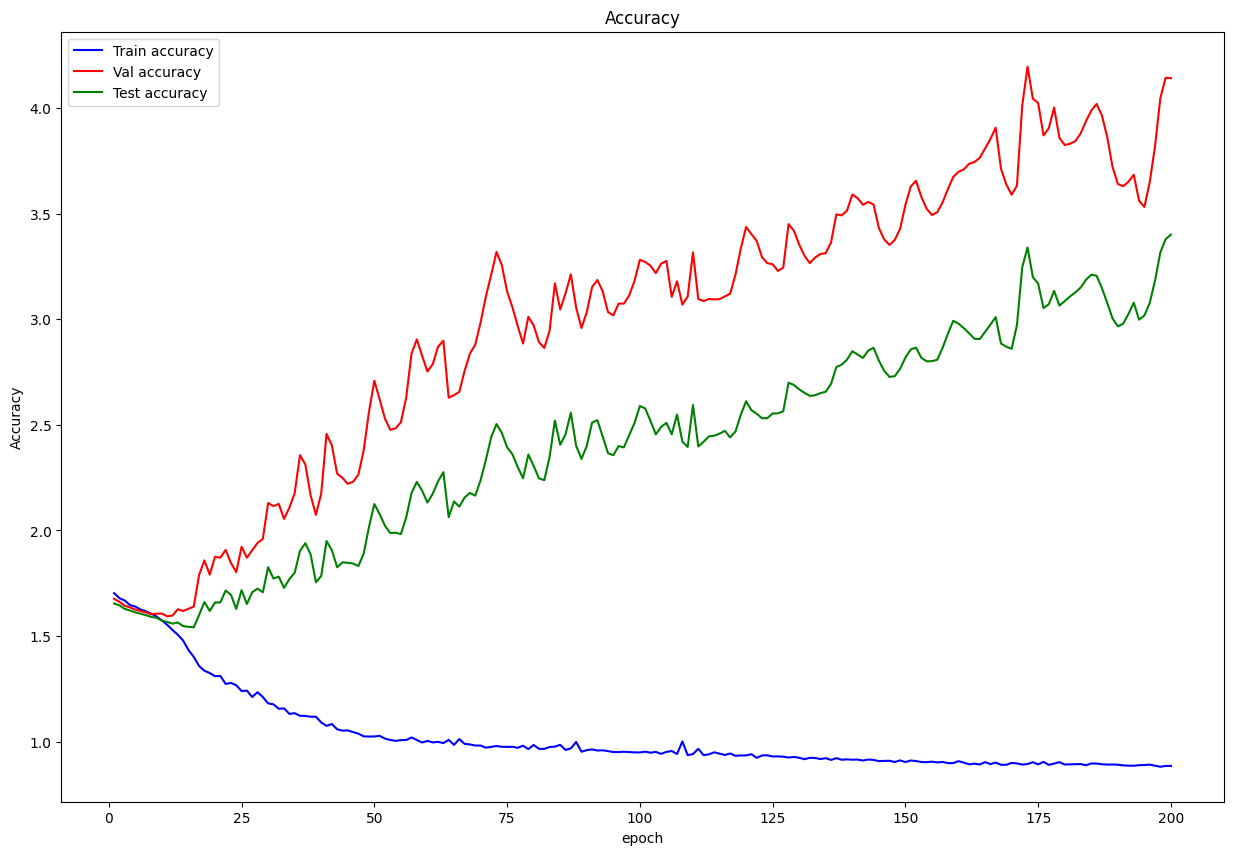

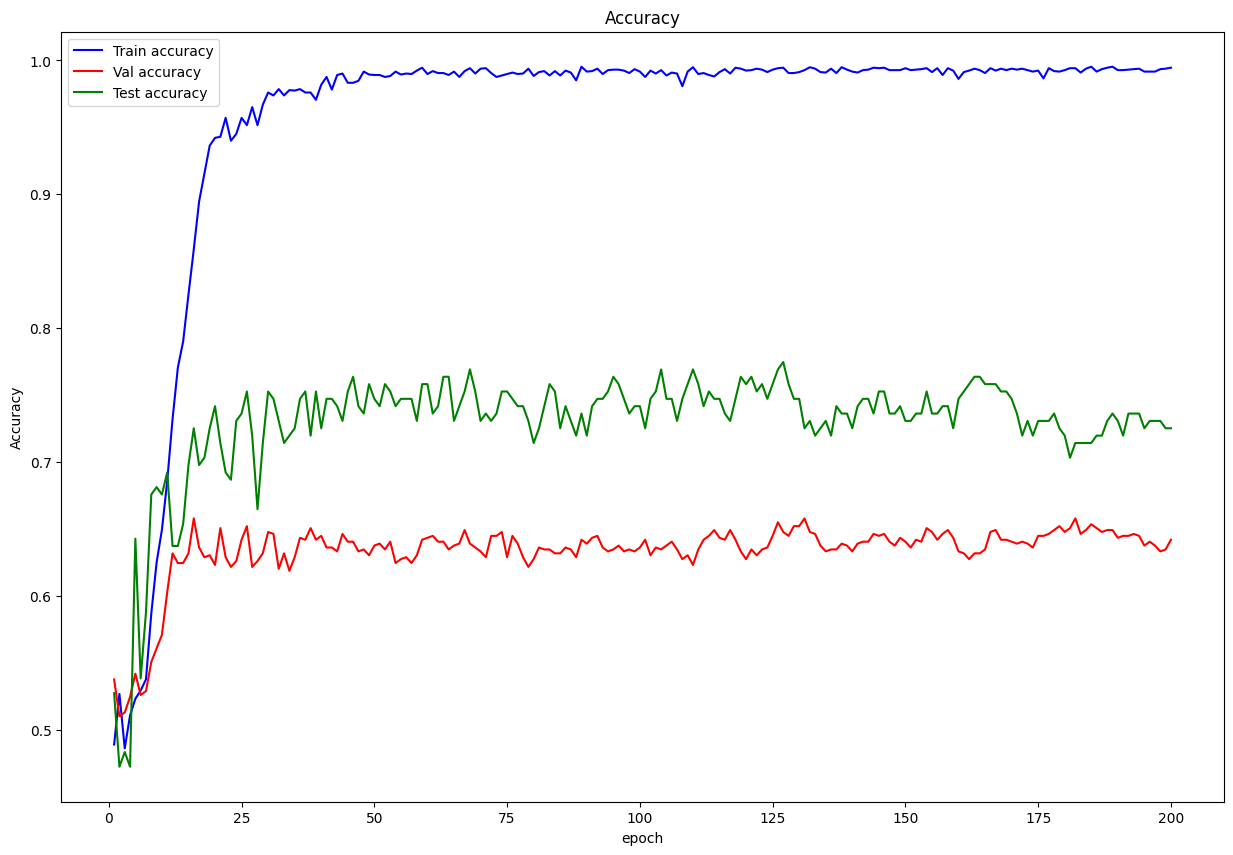



In ensemble  1
The best validaiton accuracy is:  0.6579710144927536
Happened at epoch:  182
The corresponding test accuracy 0.7142857142857143
The corresponding test AUC is:  0.7949370155038759




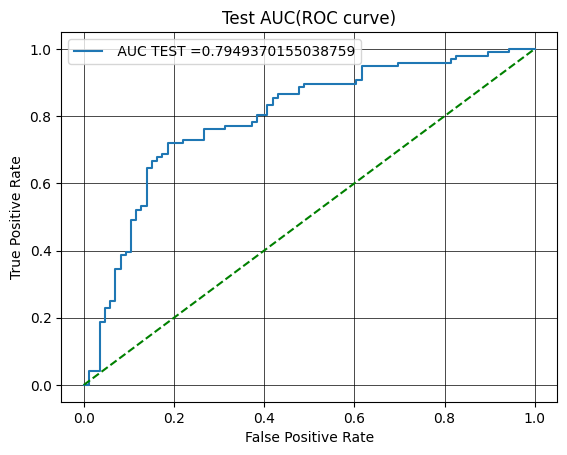



Ensemble  2
Fitting estimator with 19900 features.


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

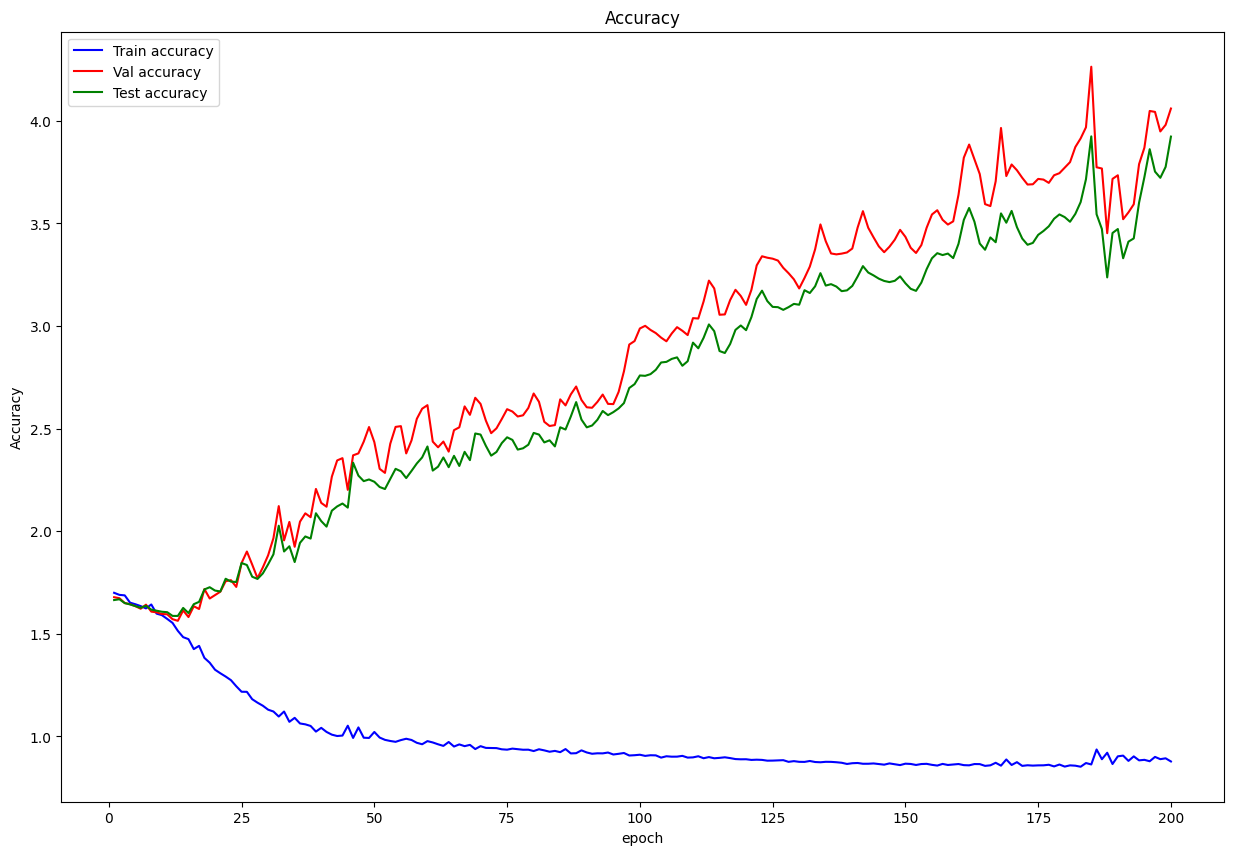

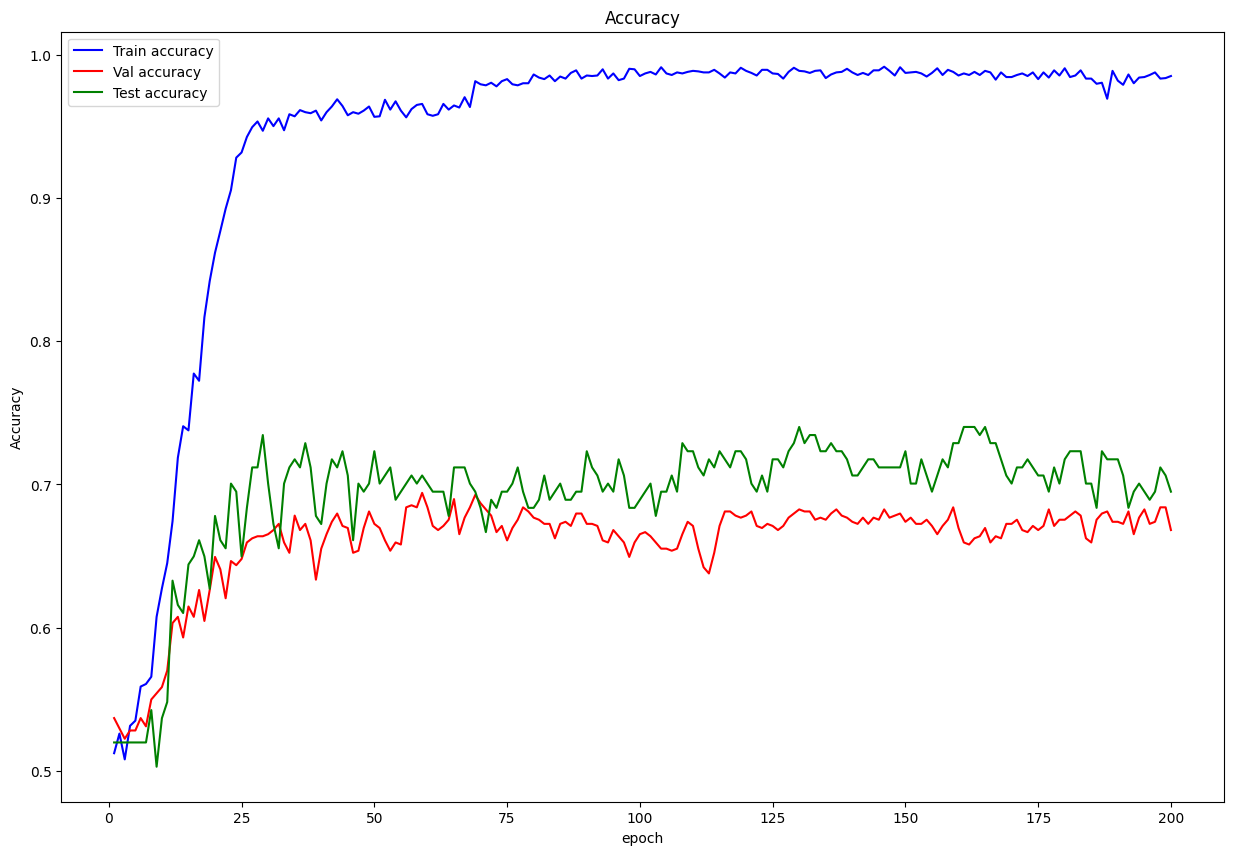



In ensemble  2
The best validaiton accuracy is:  0.6940836940836941
Happened at epoch:  59
The corresponding test accuracy 0.7062146892655368
The corresponding test AUC is:  0.7459079283887469




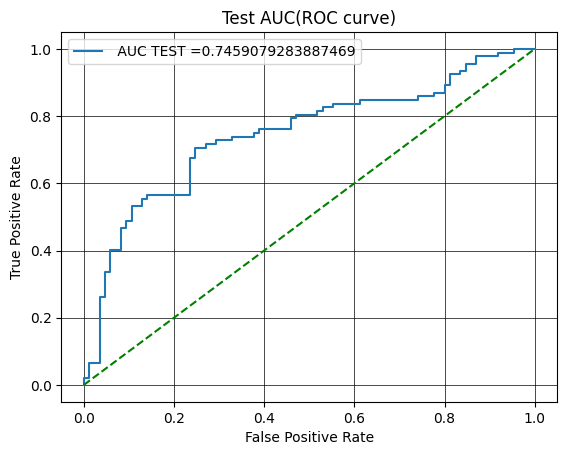



Ensemble  3
Fitting estimator with 19900 features.


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

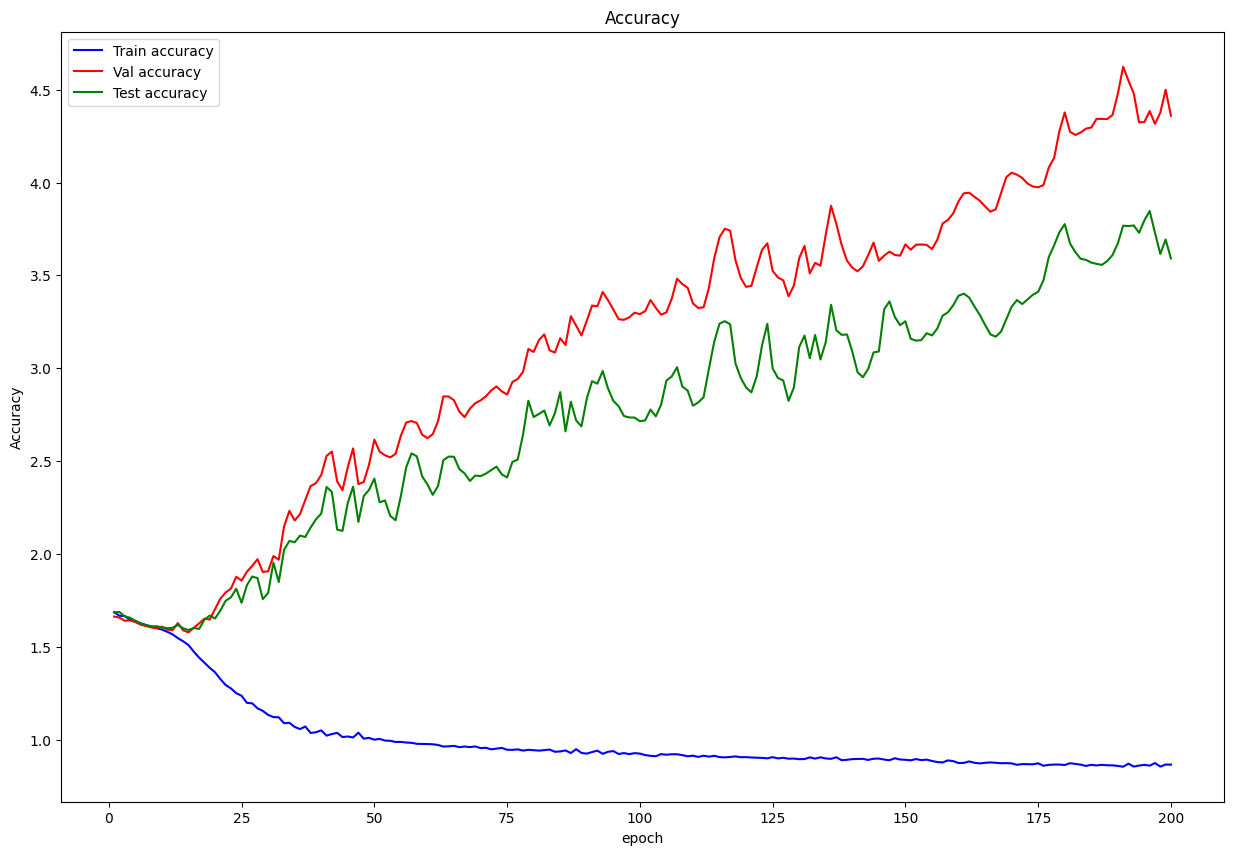

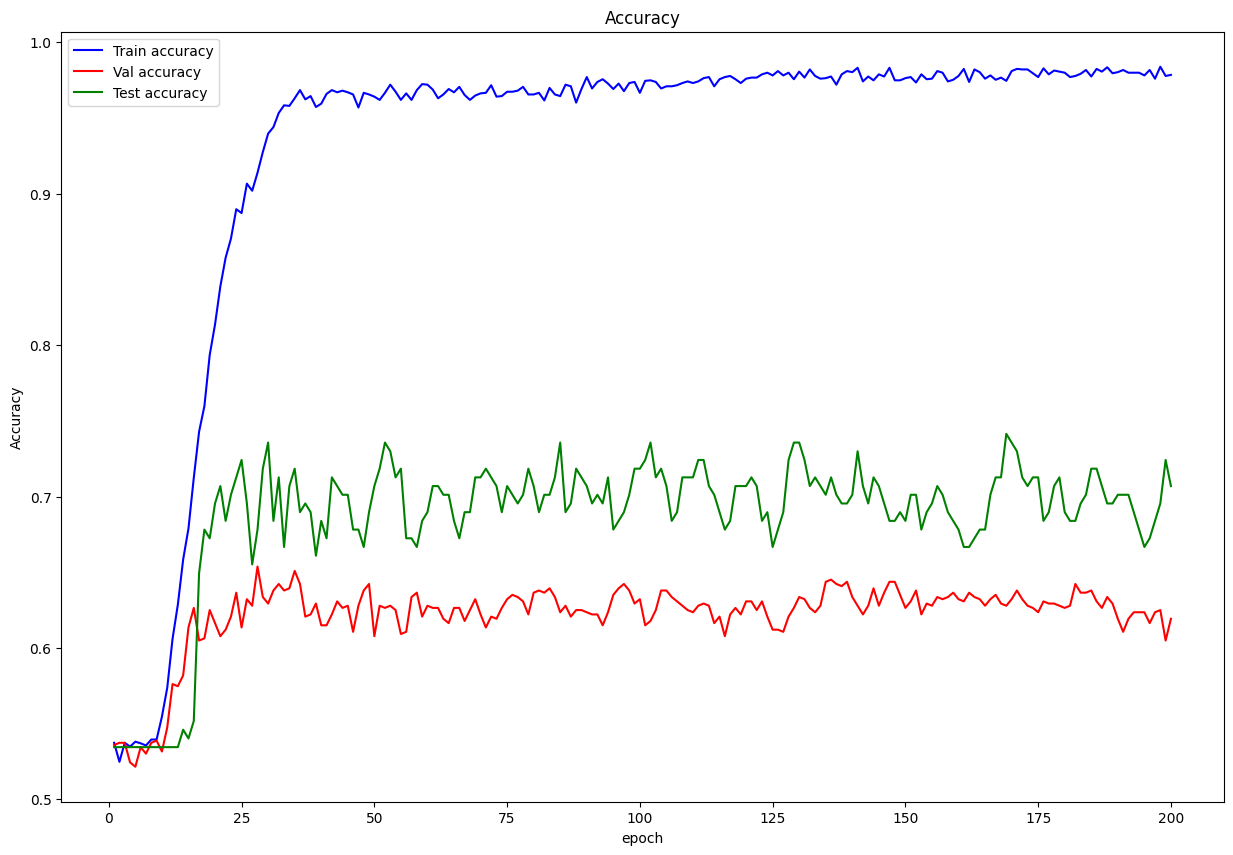



In ensemble  3
The best validaiton accuracy is:  0.6537356321839081
Happened at epoch:  28
The corresponding test accuracy 0.6781609195402298
The corresponding test AUC is:  0.760785875481216




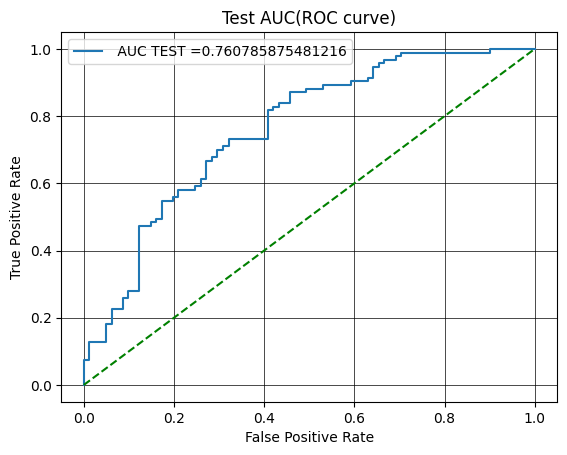



Ensemble  4
Fitting estimator with 19900 features.


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

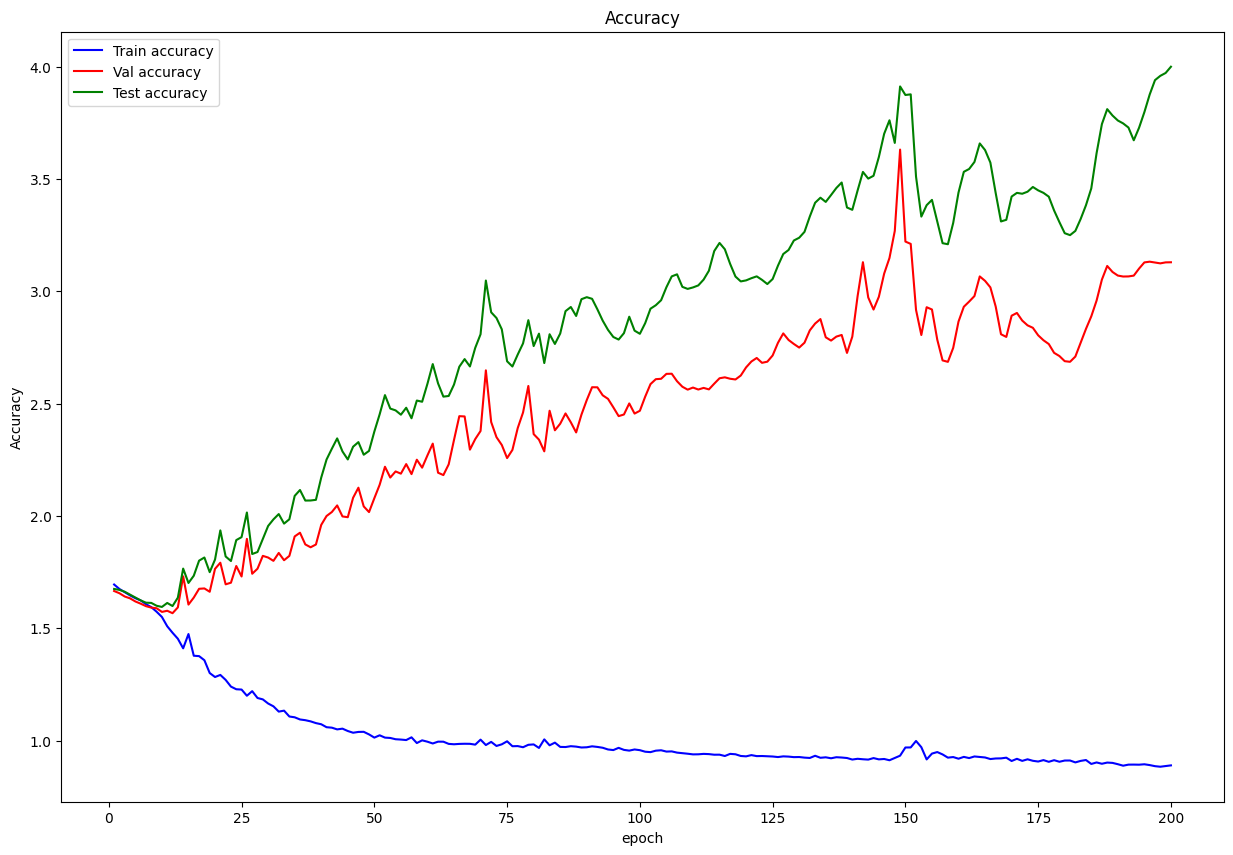

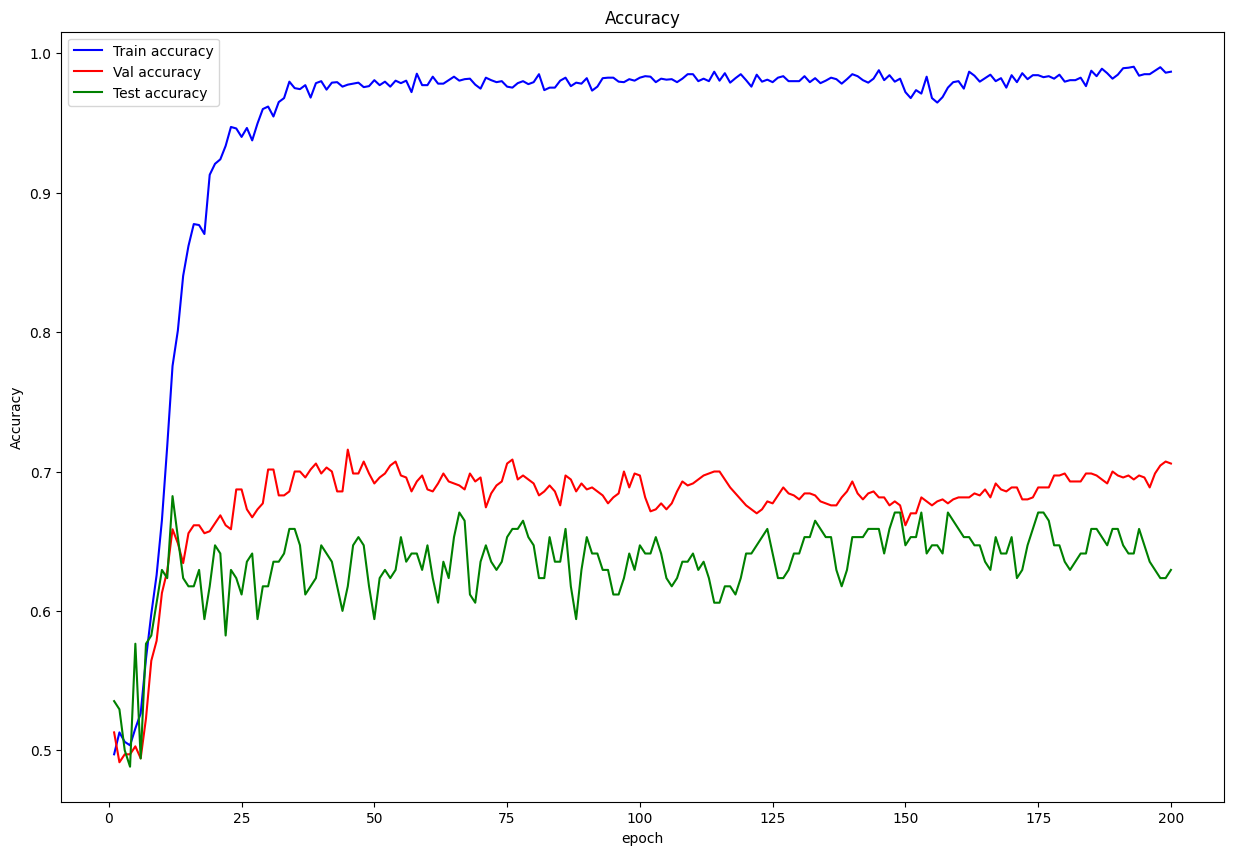



In ensemble  4
The best validaiton accuracy is:  0.7157142857142857
Happened at epoch:  45
The corresponding test accuracy 0.6176470588235294
The corresponding test AUC is:  0.6914893617021276




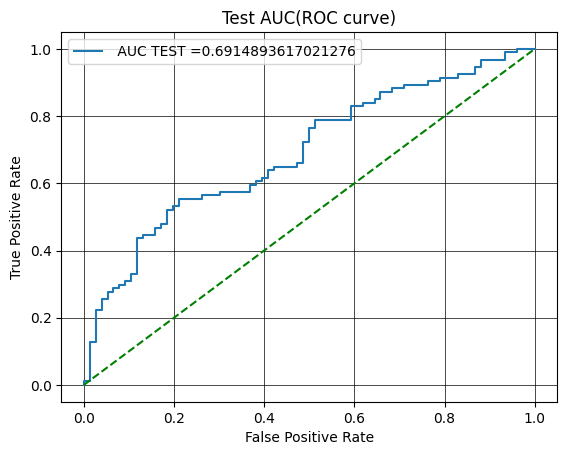



Ensemble  5
Fitting estimator with 19900 features.


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

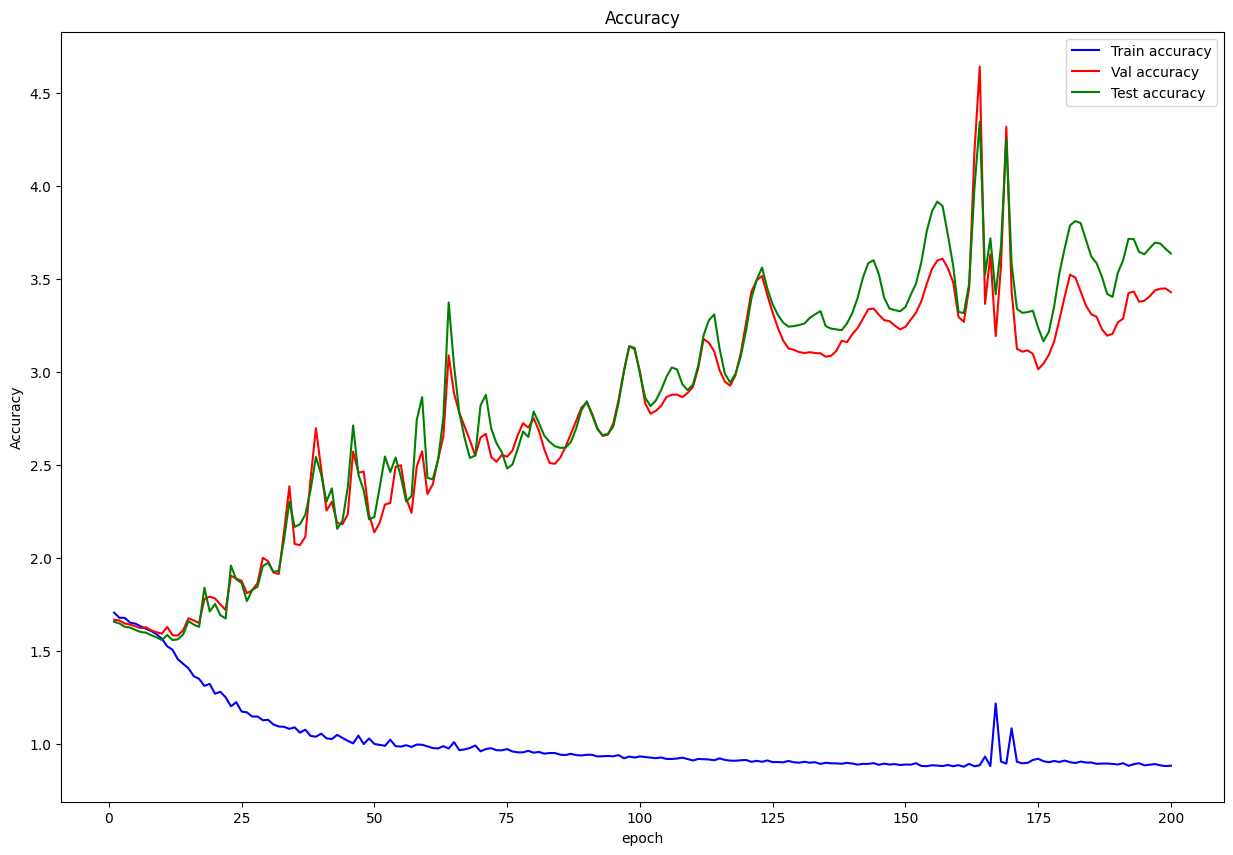

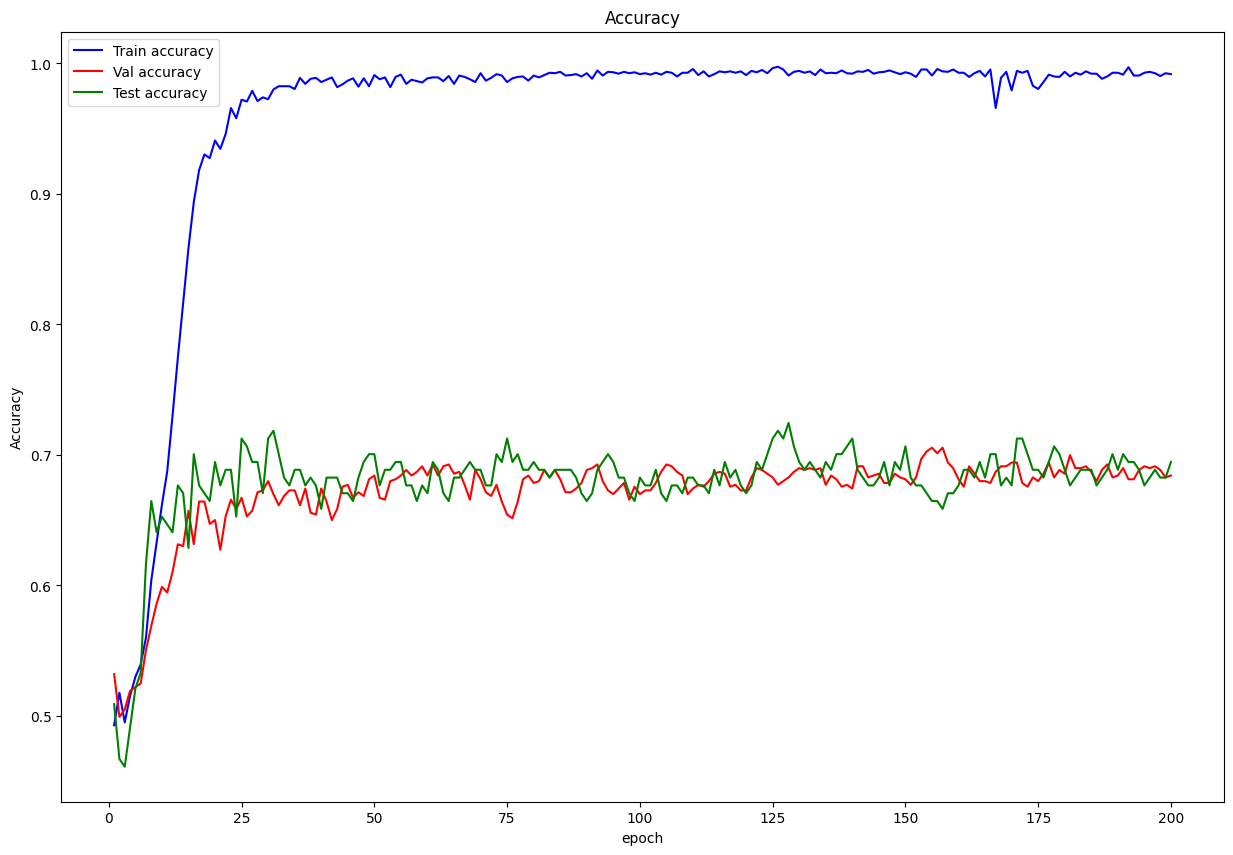



In ensemble  5
The best validaiton accuracy is:  0.705547652916074
Happened at epoch:  157
The corresponding test accuracy 0.6586826347305389
The corresponding test AUC is:  0.7333333333333334




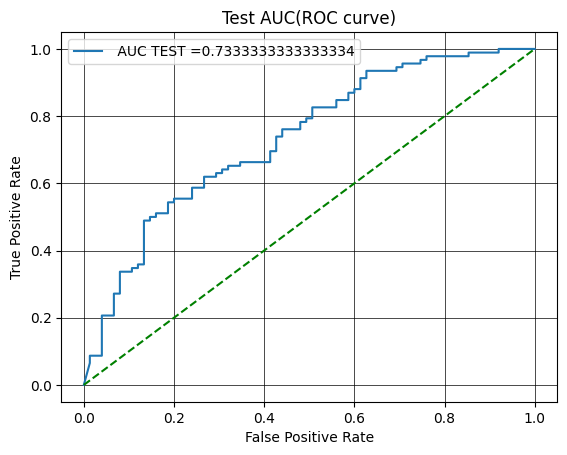



The Max voting test accuracy is:  0.6758620689655173
The test AUC is:  0.7403547271268485






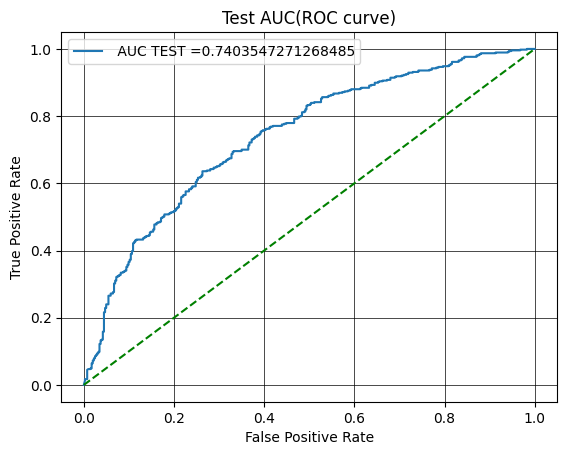

In [25]:
torch.cuda.empty_cache()
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)
############################################### Max voting ###############################################################
############################################### Max voting ###############################################################
############################################### Max voting ###############################################################
dist_ensemble_val_label = {}
dist_ensemble_val_result = {}
dist_ensemble_test_label = {}
dist_ensemble_test_result = {}
dist_ensemble_test_prob = {}

for ensemble_fold in range(5):
  print('Ensemble ',ensemble_fold+1)
  save_ensemble_models_path = save_path + 'Max_voting/AUTO/'
  dist_train = {}
  dist_validation = {}
  dist_test = {}
  for i in range(k_fold):
    dist_train[str(i + 1)] = []
    dist_validation[str(i + 1)] = []
    dist_test[str(i + 1)] = []
  test_name = {}
  for i in range(len(unique_sites)):
    test_name[unique_sites[i]] = []
  for each_site in unique_sites:
    index_site = get_index(sites, each_site)
    label = np.zeros((len(index_site)))
    for i in range(len(index_site)):
      index = index_site[i]
      label[i] = int(labels[int(index)])
    test_name_list = test_name[each_site]
    ########################################### StratifiedKFold ####################################################
    sfolder = StratifiedKFold(n_splits=k_fold,random_state=0,shuffle=True)
    group = 0
    for train, validation in sfolder.split(index_site,label):
      if group == ensemble_fold:
        for j in validation:
          name = index_site[j]
          dist_test['1'].append(name)
          dist_test['2'].append(name)
          dist_test['3'].append(name)
          dist_test['4'].append(name)
          dist_test['5'].append(name)
          test_name_list.append(name)
      group = group + 1
    test_name[each_site] = test_name_list

  for each_site in unique_sites:
    if ensemble_fold == 0:

      index_site = get_index(sites, each_site)
      label = np.zeros((len(index_site)))
      for i in range(len(index_site)):
        index = index_site[i]
        label[i] = int(labels[int(index)])
      test_name_list = test_name[each_site]
      index_site_new = []
      label_new = np.zeros((len(index_site) - len(test_name_list)))
      position = 0
      for x in range(len(index_site)):
        sample_name = index_site[x]
        if sample_name in test_name_list:
          c=0
        else:
          index_site_new.append(sample_name)
          label_new[position] = label[x]
          position = position + 1
      if each_site == 'CMU':  # ONLY 4 AUTISM SAMPLES AND 4 TD SAMPLES, CAN NOT BE DEVIDED INTO 5 GROUPS
        group_autism_val = []
        group_autism_train = []
        group_TD_val = []
        group_TD_train = []
        autism_validation_number = len(label_new[label_new ==1])/4
        TD_validation_number = len(label_new[label_new ==0]) / 4
        for j in range(len(label_new)):
          if label_new[j] == 1:
            if len(group_autism_val)<autism_validation_number:
              group_autism_val.append(index_site_new[j])
            else:
              group_autism_train.append(index_site_new[j])
          else:
            if len(group_TD_val)<TD_validation_number:
              group_TD_val.append(index_site_new[j])
            else:
              group_TD_train.append(index_site_new[j])

        dist_validation['1'] = dist_validation['1'] + group_autism_val + group_TD_val
        dist_validation['2'] = dist_validation['2'] + group_autism_val + group_TD_val
        dist_validation['3'] = dist_validation['3'] + group_autism_val + group_TD_val
        dist_validation['4'] = dist_validation['4'] + group_autism_val + group_TD_val
        dist_validation['5'] = dist_validation['5'] + group_autism_val + group_TD_val
        dist_train['1'] = dist_train['1'] + group_autism_train + group_TD_train
        dist_train['2'] = dist_train['2'] + group_autism_train + group_TD_train
        dist_train['3'] = dist_train['3'] + group_autism_train + group_TD_train
        dist_train['4'] = dist_train['4'] + group_autism_train + group_TD_train
        dist_train['5'] = dist_train['5'] + group_autism_train + group_TD_train
      else:
        ########################################### StratifiedKFold ####################################################
        sfolder = StratifiedKFold(n_splits=k_fold, random_state=0, shuffle=True)
        group = 0
        for train, validation in sfolder.split(index_site_new, label_new):

          for i in train:
            name = index_site_new[i]
            dist_train[str(group + 1)].append(name)
          for j in validation:
            name = index_site_new[j]
            dist_validation[str(group + 1)].append(name)
          group = group + 1
    else:

      index_site = get_index(sites, each_site)
      label = np.zeros((len(index_site)))
      for i in range(len(index_site)):
        index = index_site[i]
        label[i] = int(labels[int(index)])
      test_name_list = test_name[each_site]
      index_site_new = []
      label_new = np.zeros((len(index_site) - len(test_name_list)))
      position = 0
      for x in range(len(index_site)):
        sample_name = index_site[x]
        if sample_name in test_name_list:
          c=0
        else:
          index_site_new.append(sample_name)
          label_new[position] = label[x]
          position = position + 1
      ########################################### StratifiedKFold ####################################################
      sfolder = StratifiedKFold(n_splits=k_fold,random_state=0,shuffle=True)
      group = 0
      for train, validation in sfolder.split(index_site_new,label_new):

        for i in train:
          name = index_site_new[i]
          dist_train[str(group + 1)].append(name)
        for j in validation:
          name = index_site_new[j]
          dist_validation[str(group + 1)].append(name)
        group = group+1


  data = {}
  for fold in range(1, k_fold+1):
    data[str(fold)] = []
    ################################################# feature selection #########################################################
    selector_fMRI = feature_selection_fMRI(fMRI_images, labels, dist_train[str(fold)], new_number_features_fMRI)
    selector_sMRI = feature_selection_sMRI(sMRI_features, labels, dist_train[str(fold)], new_number_features_sMRI)

    new_fMRI_data = selector_fMRI.transform(fMRI_images)
    new_sMRI_data = selector_sMRI.transform(sMRI_features)
    ################################################# combine ##########################################
    if phe == True:
      fold_data = np.concatenate((new_fMRI_data,new_sMRI_data,phe_features), axis = 1)
      print(fold_data.shape)
    else:
      fold_data = np.concatenate((new_fMRI_data,new_sMRI_data), axis = 1)
      print(fold_data.shape)

    data[str(fold)].append(fold_data)
    data[str(fold)].append(AUTO_labels)

  ############################################### Train ###############################################################
  ############################################### Train ###############################################################
  ############################################### Train ###############################################################

  model_1 = Auto_encoder_MLP(in_c=args.auto_in, auto_1=args.auto_hid_1, auto_2=args.auto_hid_2, auto_3=args.auto_hid_3, MLP_1=args.MLP_1, MLP_2=args.MLP_2, MLP_out=args.MLP_out, dropout_rate=args.dropout_rate)
  model_2 = Auto_encoder_MLP(in_c=args.auto_in, auto_1=args.auto_hid_1, auto_2=args.auto_hid_2, auto_3=args.auto_hid_3, MLP_1=args.MLP_1, MLP_2=args.MLP_2, MLP_out=args.MLP_out, dropout_rate=args.dropout_rate)
  model_3 = Auto_encoder_MLP(in_c=args.auto_in, auto_1=args.auto_hid_1, auto_2=args.auto_hid_2, auto_3=args.auto_hid_3, MLP_1=args.MLP_1, MLP_2=args.MLP_2, MLP_out=args.MLP_out, dropout_rate=args.dropout_rate)
  model_4 = Auto_encoder_MLP(in_c=args.auto_in, auto_1=args.auto_hid_1, auto_2=args.auto_hid_2, auto_3=args.auto_hid_3, MLP_1=args.MLP_1, MLP_2=args.MLP_2, MLP_out=args.MLP_out, dropout_rate=args.dropout_rate)
  model_5 = Auto_encoder_MLP(in_c=args.auto_in, auto_1=args.auto_hid_1, auto_2=args.auto_hid_2, auto_3=args.auto_hid_3, MLP_1=args.MLP_1, MLP_2=args.MLP_2, MLP_out=args.MLP_out, dropout_rate=args.dropout_rate)

  gpu_ids = range(args.ngpu)
  model_1 = nn.parallel.DataParallel(model_1, device_ids=gpu_ids)
  model_2 = nn.parallel.DataParallel(model_2, device_ids=gpu_ids)
  model_3 = nn.parallel.DataParallel(model_3, device_ids=gpu_ids)
  model_4 = nn.parallel.DataParallel(model_4, device_ids=gpu_ids)
  model_5 = nn.parallel.DataParallel(model_5, device_ids=gpu_ids)
  train = train_AUTO

  print('  + Number of params: {}'.format(
      sum([p.data.nelement() for p in model_1.parameters()])))
  if args.cuda:
      model_1 = model_1.cuda()
      model_2 = model_2.cuda()
      model_3 = model_3.cuda()
      model_4 = model_4.cuda()
      model_5 = model_5.cuda()

  optimizer_1 = optim.Adam(model_1.parameters(), lr = args.lr)
  optimizer_2 = optim.Adam(model_2.parameters(), lr = args.lr)
  optimizer_3 = optim.Adam(model_3.parameters(), lr = args.lr)
  optimizer_4 = optim.Adam(model_4.parameters(), lr = args.lr)
  optimizer_5 = optim.Adam(model_5.parameters(), lr = args.lr)

  Train_accuracy_list =[]
  Train_loss_list = []
  Val_accuracy_list =[]
  Val_loss_list = []
  Test_accuracy_list =[]
  Test_loss_list = []
  best_validation_accuracy = 0

  for epoch in range(1, args.nEpochs + 1):


    model_1, train_target_1, train_out_1, train_loss_1, val_target_1, val_out_1, val_loss_1, test_target_1, test_out_1, test_prob_1, test_loss_1 = train(args, model_1, data['1'], dist_train['1'], dist_validation['1'], dist_test['1'], optimizer_1)
    model_2, train_target_2, train_out_2, train_loss_2, val_target_2, val_out_2, val_loss_2, test_target_2, test_out_2, test_prob_2, test_loss_2 = train(args, model_2, data['2'], dist_train['2'], dist_validation['2'], dist_test['2'], optimizer_2)
    model_3, train_target_3, train_out_3, train_loss_3, val_target_3, val_out_3, val_loss_3, test_target_3, test_out_3, test_prob_3, test_loss_3 = train(args, model_3, data['3'], dist_train['3'], dist_validation['3'], dist_test['3'], optimizer_3)
    model_4, train_target_4, train_out_4, train_loss_4, val_target_4, val_out_4, val_loss_4, test_target_4, test_out_4, test_prob_4, test_loss_4 = train(args, model_4, data['4'], dist_train['4'], dist_validation['4'], dist_test['4'], optimizer_4)
    model_5, train_target_5, train_out_5, train_loss_5, val_target_5, val_out_5, val_loss_5, test_target_5, test_out_5, test_prob_5, test_loss_5 = train(args, model_5, data['5'], dist_train['5'], dist_validation['5'], dist_test['5'], optimizer_5)

    train_target_all = np.concatenate((train_target_1, train_target_2, train_target_3, train_target_4, train_target_5),axis = 0)
    train_out_all = np.concatenate((train_out_1, train_out_2, train_out_3, train_out_4, train_out_5),axis = 0)
    train_loss = (train_loss_1 + train_loss_2 + train_loss_3 + train_loss_4 + train_loss_5)/5
    val_target_all = np.concatenate((val_target_1, val_target_2, val_target_3, val_target_4, val_target_5),axis = 0)
    val_out_all = np.concatenate((val_out_1, val_out_2, val_out_3, val_out_4, val_out_5),axis = 0)
    val_loss = (val_loss_1 + val_loss_2 + val_loss_3 + val_loss_4 + val_loss_5)/5
    test_target_all = test_target_1 # test_target_1 = test_target_2 = test_target_3 = test_target_4 = test_target_5
    test_out_all = test_out_1 + test_out_2 + test_out_3 + test_out_4 + test_out_5
    test_prob_all = (test_prob_1 + test_prob_2 + test_prob_3 + test_prob_4 + test_prob_5)/5
    test_loss = (test_loss_1 + test_loss_2 + test_loss_3 + test_loss_4 + test_loss_5)/5

    test_results_binary = np.zeros_like((test_out_all))
    test_results_binary[test_out_all<2.5] = 0
    test_results_binary[test_out_all>=2.5] = 1

    train_accuracy = metrics.accuracy_score(train_target_all, train_out_all)
    val_accuracy = metrics.accuracy_score(val_target_all, val_out_all)
    test_accuracy = metrics.accuracy_score(test_target_all, test_results_binary)
    Train_accuracy_list.append(train_accuracy)
    Val_accuracy_list.append(val_accuracy)
    Test_accuracy_list.append(test_accuracy)
    Train_loss_list.append(train_loss)
    Val_loss_list.append(val_loss)
    Test_loss_list.append(test_loss)

    if val_accuracy >=best_validation_accuracy:
      best_epoch = epoch
      best_validation_accuracy = val_accuracy
      corresponding_test_accuracy = test_accuracy
      corresponding_test_prob = test_prob_all
      corresponding_test_labels = test_target_all
      corresponding_test_out = test_results_binary
      print('Save models')

      save_model(model_1, save_ensemble_models_path, 'AUTO_ensemble' + str(ensemble_fold) + '_1')
      save_model(model_2, save_ensemble_models_path, 'AUTO_ensemble' + str(ensemble_fold) + '_2')
      save_model(model_3, save_ensemble_models_path, 'AUTO_ensemble' + str(ensemble_fold) + '_3')
      save_model(model_4, save_ensemble_models_path, 'AUTO_ensemble' + str(ensemble_fold) + '_4')
      save_model(model_5, save_ensemble_models_path, 'AUTO_ensemble' + str(ensemble_fold) + '_5')

    print('Train Epoch: ' + str(epoch) + ': train loss : {:.8f}\t train accuracy : {:.8f}\t val accuracy : {:.8f}\t test accuracy : {:.8f}\t'.format(
      train_loss, train_accuracy, val_accuracy, test_accuracy))

  x_axis = list(range(1, len(Train_accuracy_list)+1))
  plt.figure(figsize=(15,10))
  plt.plot(x_axis, Train_loss_list, c='b',label='Train accuracy')
  plt.plot(x_axis, Val_loss_list, c='r',label='Val accuracy')
  plt.plot(x_axis, Test_loss_list, c='g',label='Test accuracy')
  plt.title("Accuracy")
  plt.xlabel("epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

  plt.figure(figsize=(15,10))
  plt.plot(x_axis, Train_accuracy_list, c='b',label='Train accuracy')
  plt.plot(x_axis, Val_accuracy_list, c='r',label='Val accuracy')
  plt.plot(x_axis, Test_accuracy_list, c='g',label='Test accuracy')
  plt.title("Accuracy")
  plt.xlabel("epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

  test_fpr, test_tpr, te_thresholds = roc_curve(corresponding_test_labels, corresponding_test_prob[:,1],pos_label=1)
  test_auc = auc(test_fpr, test_tpr)
  print('\n')
  print('In ensemble ',ensemble_fold+1)
  print('The best validaiton accuracy is: ',best_validation_accuracy)
  print('Happened at epoch: ',best_epoch)
  print('The corresponding test accuracy', corresponding_test_accuracy)
  print('The corresponding test AUC is: ',test_auc)
  print('\n')


  plt.grid()
  plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
  plt.plot([0,1],[0,1],'g--')
  plt.legend()
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Test AUC(ROC curve)")
  plt.grid(color='black', linestyle='-', linewidth=0.5)
  plt.show()


  dist_ensemble_test_label[str(ensemble_fold+1)] = corresponding_test_labels
  dist_ensemble_test_result[str(ensemble_fold+1)] = corresponding_test_out
  dist_ensemble_test_prob[str(ensemble_fold+1)] = corresponding_test_prob
  print('\n')

  torch.cuda.empty_cache()

test_labels_concat = np.concatenate((dist_ensemble_test_label['1'], dist_ensemble_test_label['2'],  dist_ensemble_test_label['3'], dist_ensemble_test_label['4'], dist_ensemble_test_label['5']),axis = 0)
test_results_concat = np.concatenate((dist_ensemble_test_result['1'], dist_ensemble_test_result['2'],  dist_ensemble_test_result['3'], dist_ensemble_test_result['4'], dist_ensemble_test_result['5']),axis = 0)
test_probs_concat = np.concatenate((dist_ensemble_test_prob['1'], dist_ensemble_test_prob['2'],  dist_ensemble_test_prob['3'], dist_ensemble_test_prob['4'], dist_ensemble_test_prob['5']),axis = 0)

test_accuracy = metrics.accuracy_score(test_labels_concat, test_results_concat)
test_fpr, test_tpr, te_thresholds = roc_curve(test_labels_concat, test_probs_concat[:,1],pos_label=1)
test_auc = auc(test_fpr, test_tpr)
print('The Max voting test accuracy is: ',test_accuracy)
print('The test AUC is: ',test_auc)

print('\n')
print('\n')
plt.grid()
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()



